In [506]:
import requests
import pandas as pd
from datetime import datetime
import time
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy
import html
from ftfy import fix_text
# from bs4 import BeautifulSoup
from nltk.util import ngrams
import matplotlib.gridspec as gridspec
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer #, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from collections import defaultdict #Counter,
# from nltk.tokenize import sent_tokenize 
import random
# from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

nlp = spacy.load('en_core_web_sm') #Load spacy model for further lemmatization (if there is one)


## **Table of contents**  <a class="anchor" id="toc"></a>
### 1. [Data Collection](#first-bullet)   
### 2. [Data Preprocessing](#second-bullet)  
### 3. [Graphical representation of the dataset](#third-bullet)  
### 4. [Categorisation of the posts](#fourth-bullet)

# __1. Data Collection <a class="anchor" id="first-bullet"></a>__  
[Table of Contents](#toc)   

I've written a function called `fetch_questions` that's designed to gather questions from Stack Overflow related to Natural Language Processing (NLP) and related areas.

Here's a step-by-step explanation:

1.  **Setting up the API:**
    * I start by defining the base URL for the Stack Exchange API, which is where I'll be requesting the data from.
    * I initialize an empty list called `all_questions` to store all the questions I retrieve.
    * I have a list of tags related to NLP, like 'nlp', 'language-model', 'text-classification', and many more. This list is important because I'll use these tags to filter the questions I want.
    * I define a dictionary called 'params' that contains all the parameters that will be passed to the stackoverflow api. These parameters include:
        * 'page_size': how many questions should be returned per page.
        * 'accepted': only return questions that have accepted answers.
        * 'order': order the returned questions by their creation date.
        * 'sort': sort the returned questions by their creation date.
        * 'site': the site to get the questions from, which is stackoverflow.
        * 'tagged': the tag to filter the questions by.
        * 'key': my api key.
        * 'filter': include the body of the question in the returned data.

2.  **Looping through Pages and Tags:**
    * I use a `while` loop to keep fetching questions until I have at least 30,000 questions.
    * Inside the loop, I set the `page` and `tagged` parameters in my request.
    * I make a request to the Stack Exchange API using the `requests.get()` function.
    * I check if the API request was successful (status code 200). If not, I print an error message and stop.
    * I print out the page number to monitor the progress of the data fetching.
    * I then extract the 'items' from the json response, which are the questions, and append them to the 'all_questions' list.
    * I increse the size variable, that keeps track of how many questions have been added.
    * I add a small delay using `time.sleep(1)` to avoid overwhelming the API.
    * I increment the page number.
    * I check if there are more pages for the current tag. If not, I move to the next tag in the list.
    * If all tags have been processed, the loop stops.

3.  **Returning the Results:**
    * Finally, I return the `all_questions` list, which now contains all the fetched questions.

4.  **Creating a DataFrame:**
    * Outside the function, I call `fetch_questions()` to get the questions.
    * I then convert the list of questions into a Pandas DataFrame for easier data manipulation.

In essence, I'm using the Stack Exchange API to gather a large dataset of NLP-related questions from Stack Overflow, ensuring I only get questions with accepted answers. I'm iterating through multiple pages and tags to gather enough data. Then, I convert this data into a Pandas DataFrame.


In [ ]:

def fetch_questions(pages=200, page_size=30):
    """
    Fetches Stack Overflow questions related to Natural Language Processing (NLP) and related topics using the Stack Exchange API.

    Args:
        pages (int, optional): The maximum number of pages to fetch. Defaults to 200.
        page_size (int, optional): The number of questions to fetch per page. Defaults to 100.
    Returns:
        list: A list of dictionaries, where each dictionary represents a question.
    """

    BASE_URL = "https://api.stackexchange.com/2.3/search/advanced"
    all_questions = []

    tags = ['nlp', 'language-model', 'text-classification', 'word-embedding', 'spacy', 'nltk', 'seq2seq',
            'sentence-similarity', 'named-entity-recognition', 'text-processing', 'text-mining',
            'sentiment-analysis', 'stemming', 'lemmatization', "huggingface-transformers",
            'tokenization', 'lstm', 'chatbot', 'language-detection', 'speech-to-text',
            'text-to-speech', 'gensim', 'deep-learning', 'machine-learning']  # Supplement 'nlp' if needed.

    params = {
        'page_size': 30,  # Number of questions per page from the API.
        'accepted': 'True',  # Fetch only questions with accepted answers.
        'order': 'desc',  # Order results by creation date (newest first).
        'sort': 'creation',  # Sort by creation date.
        'site': 'stackoverflow',  # Stack Overflow site.
        'tagged': 'nlp',  # Initial tag to filter by.
        'key': 'rl_GXP3yYDC5NCfRWViwHuhPwMAZ',  # My API key.
        'filter': 'withbody',  # Include question body in the response.
    }

    page = 1
    cur_tag = 0
    size = 0
    while size < 30000:  # Ensure we collect at least 30,000 questions, even if it requires using multiple related tags.
        params["page"] = page
        params["tagged"] = tags[cur_tag]
        response = requests.get(BASE_URL, params=params)
        if response.status_code != 200:  # Handle API request errors.
            print(f"Error on page {page}: {response.status_code}. Skipping this page.")
            break

        if page % 20 == 1:  # Print progress every 20 pages.
            print(f"Fetching data from {page}-th page of tag {tags[cur_tag]}...")

        data = response.json()
        all_questions.extend(data.get("items", []))
        size += params['page_size']  # Track total questions fetched.
        time.sleep(1)  # Prevent API rate limiting.
        page += 1
        if data["has_more"] == False:  # Move to the next tag if no more pages for the current tag.
            cur_tag += 1
            page = 1
            if cur_tag + 1 > len(tags):
                break
    return all_questions

questions = fetch_questions()
df = pd.DataFrame(questions)

Fetching data from 1-th page of tag nlp...
Fetching data from 21-th page of tag nlp...
Fetching data from 41-th page of tag nlp...
Fetching data from 61-th page of tag nlp...
Fetching data from 81-th page of tag nlp...
Fetching data from 101-th page of tag nlp...
Fetching data from 121-th page of tag nlp...
Fetching data from 141-th page of tag nlp...
Fetching data from 161-th page of tag nlp...
Fetching data from 181-th page of tag nlp...
Fetching data from 201-th page of tag nlp...
Fetching data from 221-th page of tag nlp...
Fetching data from 241-th page of tag nlp...
Fetching data from 261-th page of tag nlp...
Fetching data from 281-th page of tag nlp...
Fetching data from 1-th page of tag language-model...
Fetching data from 1-th page of tag text-classification...
Fetching data from 21-th page of tag text-classification...
Fetching data from 1-th page of tag word-embedding...
Fetching data from 1-th page of tag spacy...
Fetching data from 21-th page of tag spacy...
Fetching data

In [ ]:
df.to_csv("nlp_questions.csv", index = False)

In [ ]:
df.head()

tags  \
0  [numpy, nlp, dependencies, google-colaboratory...   
1                [python, nlp, large-language-model]   
2          [python, nlp, spacy, langchain, presidio]   
3                                     [nlp, opennlp]   
4                          [python, python-3.x, nlp]   

                                               owner  is_answered  view_count  \
0  {'account_id': 8652474, 'reputation': 687, 'us...         True          89   
1  {'account_id': 1230089, 'reputation': 5390, 'u...         True          26   
2  {'account_id': 22369526, 'reputation': 69, 'us...         True         210   
3  {'account_id': 21332, 'reputation': 5495, 'use...         True          32   
4  {'account_id': 3657839, 'reputation': 1081, 'u...         True          48   

    closed_date  accepted_answer_id  answer_count  score  last_activity_date  \
0  1.743076e+09            79523777             1      0          1742494070   
1           NaN            79501337             1      0          1741708699   
2           NaN            79495969             2      4          1742055531   
3           NaN            79475445             1      1          1740743750   
4           NaN            79461281             1      1          1740316677   

   creation_date  ...  closed_reason  \
0     1742481362  ...      Duplicate   
1     1741704631  ...            NaN   
2     1741040827  ...            NaN   
3     1740240371  ...            NaN   
4     1739980065  ...            NaN   

                                               title  \
0  Trouble getting importing gensim to work in colab   
1        Store images instead of showing in a server   
2  Presidio with Langchain Experimental does not ...   
3          OpenNLP POSTaggerME and ChunkerME synergy   
4                        word/ sentence similarities   

                                                body content_license  \
0  <p>I am trying to import gensim into colab.</p...             NaN   
1  <p>I am running the code found on this [site][...    CC BY-SA 4.0   
2  <p>I am using presidio/langchain_experimental ...    CC BY-SA 4.0   
3  <p>I'm trying to use the OpenNLP chunking API ...    CC BY-SA 4.0   
4  <p>I am trying to find if a given word/ set of...    CC BY-SA 4.0   

  last_edit_date posted_by_collectives  migrated_from protected_date  \
0            NaN                   NaN            NaN            NaN   
1            NaN                   NaN            NaN            NaN   
2   1.741330e+09                   NaN            NaN            NaN   
3   1.740586e+09                   NaN            NaN            NaN   
4   1.740151e+09                   NaN            NaN            NaN   

  community_owned_date  locked_date  
0                  NaN          NaN  
1                  NaN          NaN  
2                  NaN          NaN  
3                  NaN          NaN  
4                  NaN          NaN  

[5 rows x 22 columns]

The table above show detailed information about the dataframe including column types and non-null counts  
RangeIndex: 29838 entries, 0 to 29837 indicates we have nearly 30k rows of data  
__The dataframe has 22 columns with various data types (object, int64, float64)__

#### Display the first few rows of the dataframe and call describe() to inspect the data structure 

In [5]:
df.info() # get detailed info of this dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29638 entries, 0 to 29637
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tags                   29638 non-null  object 
 1   owner                  29638 non-null  object 
 2   is_answered            29638 non-null  bool   
 3   view_count             29638 non-null  int64  
 4   closed_date            1222 non-null   float64
 5   accepted_answer_id     29638 non-null  int64  
 6   answer_count           29638 non-null  int64  
 7   score                  29638 non-null  int64  
 8   last_activity_date     29638 non-null  int64  
 9   creation_date          29638 non-null  int64  
 10  question_id            29638 non-null  int64  
 11  link                   29638 non-null  object 
 12  closed_reason          1222 non-null   object 
 13  title                  29638 non-null  object 
 14  body                   29638 non-null  object 
 15  co

In [7]:
df.describe()

view_count   closed_date  accepted_answer_id  answer_count  \
count   29638.000000  1.222000e+03        2.963800e+04  29638.000000   
mean     3218.528983  1.529458e+09        5.129177e+07      1.538667   
std     14504.394378  1.152123e+08        2.034937e+07      1.268667   
min        17.000000  1.237286e+09        1.432000e+04      1.000000   
25%       270.000000  1.435065e+09        3.947794e+07      1.000000   
50%       794.000000  1.523265e+09        5.599391e+07      1.000000   
75%      2126.000000  1.622284e+09        6.764668e+07      2.000000   
max    682409.000000  1.743288e+09        7.953980e+07     51.000000   

              score  last_activity_date  creation_date   question_id  \
count  29638.000000        2.963800e+04   2.963800e+04  2.963800e+04   
mean       2.655037        1.560925e+09   1.537728e+09  5.105677e+07   
std       11.214839        1.010536e+08   1.084928e+08  2.040749e+07   
min       -7.000000        1.224774e+09   1.219045e+09  1.428100e+04   
25%        0.000000        1.499520e+09   1.472449e+09  3.919930e+07   
50%        1.000000        1.576867e+09   1.555628e+09  5.575412e+07   
75%        2.000000        1.636677e+09   1.620760e+09  6.749232e+07   
max      686.000000        1.743280e+09   1.743012e+09  7.953689e+07   

       last_edit_date  protected_date  community_owned_date   locked_date  
count    1.653400e+04    1.210000e+02          1.100000e+01  4.000000e+00  
mean     1.547110e+09    1.570920e+09          1.257659e+09  1.633551e+09  
std      1.043441e+08    1.142027e+08          4.049240e+07  1.481202e+08  
min      1.221484e+09    1.323585e+09          1.222973e+09  1.428079e+09  
25%      1.489814e+09    1.474630e+09          1.223689e+09  1.573780e+09  
50%      1.560217e+09    1.568320e+09          1.256184e+09  1.682118e+09  
75%      1.624829e+09    1.680241e+09          1.272131e+09  1.741890e+09  
max      1.743280e+09    1.741686e+09          1.359227e+09  1.741890e+09


__This is a dataset of Stack Exchange questions focused on NLP. The data contains 29,638 entries with 22 columns, providing a rich source of information about real-world NLP questions and challenges.__  
The insights we can gather from this descriptive statistics summary of your DataFrame:

**Specific Column Insights:**

1.  **`view_count`:**
    * Ranges widely from 17 to 682,409 views.
    * The mean (average) view count is ~3218, but the median (50th percentile) is only 794.
    * *Insight:* This difference (mean >> median) indicates a strong right-skewed distribution. Most questions have relatively few views (75% have 2126 views or fewer), while a small number of questions are extremely popular and pull the average up significantly.

2.  **`answer_count`:**
    * Most questions have few answers. The minimum is 1, the median (50%) is 1, and 75% of questions have 2 answers or fewer.
    * The mean is ~1.54.
    * The maximum is 51, showing some questions attract many answers.
    * *Insight:* Also right-skewed. Most questions get only one or two answers.

3.  **`score`:**
    * Scores range from -7 to 686.
    * The mean score is ~2.66, while the median is 1.
    * *Insight:* Right-skewed distribution. Most questions have a low score (0, 1, or 2 cover the 25th to 75th percentile range), but some achieve very high scores. Negative scores are possible but less common.

4.  **Date Columns (`closed_date`, `last_activity_date`, `creation_date`, `last_edit_date`, `protected_date`, `community_owned_date`, `locked_date`):**
    * These columns store large numerical values (e.g., $1.5 \times 10^9$).
    * *Insight:* These are almost certainly timestamps. They represent different event times associated with the questions/posts. The `min` and `max` show the time range covered by the data for each event type. The high number of missing values (low `count`) for `closed_date`, `last_edit_date`, `protected_date`, etc., reflects that these events are conditional.


**Summary Insights**

* Key features like views, answers, and scores are heavily skewed, with most entities having low values but a few having very high values.

* The date columns should likely be converted to actual datetime objects for easier time-based analysis.

This summary provides a good starting point for understanding the characteristics of data

### There are some posts might have several tags, so that if we retrieve posts data by querying with different tags, there probably are duplicated posts, here I remove duplicated posts by checking if posts' '__link__' are unique

In [2]:
# df = pd.read_excel("nlp_questions.xlsx", engine="openpyxl")

In [3]:
df_unique = df.drop_duplicates(subset=['link'], keep='first') #remove duplicated posts
df_unique = df_unique.reset_index(drop=True)
df_unique.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24776 entries, 0 to 24775
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tags                   24776 non-null  object 
 1   owner                  24775 non-null  object 
 2   is_answered            24775 non-null  object 
 3   view_count             24775 non-null  object 
 4   closed_date            1033 non-null   float64
 5   accepted_answer_id     24775 non-null  float64
 6   answer_count           24774 non-null  float64
 7   score                  24775 non-null  float64
 8   last_activity_date     24775 non-null  float64
 9   creation_date          24775 non-null  float64
 10  question_id            24775 non-null  float64
 11  link                   24775 non-null  object 
 12  closed_reason          1033 non-null   object 
 13  title                  24774 non-null  object 
 14  body                   24774 non-null  object 
 15  co

In [ ]:
# df_unique.to_csv('nlp_questions_unique.csv', index = False)

In [4]:
# Drop question with Nan/null question_id and body (because we cannot retrieve its answer if question_id is null, and drop rows with null body because there's barely content for us to implement sentiment analysis)
df_unique = df_unique.dropna(subset=['question_id', 'body'])
df_unique

tags  \
0      ['numpy', 'nlp', 'dependencies', 'google-colab...   
1              ['python', 'nlp', 'large-language-model']   
2      ['python', 'nlp', 'spacy', 'langchain', 'presi...   
3                                     ['nlp', 'opennlp']   
4                        ['python', 'python-3.x', 'nlp']   
...                                                  ...   
24771  ['python', 'numpy', 'tensorflow', 'deep-learni...   
24772  ['machine-learning', 'scikit-learn', 'deep-lea...   
24773  ['python', 'deep-learning', 'pytorch', 'conv-n...   
24774  ['deep-learning', 'computer-vision', 'object-d...   
24775               ['deep-learning', 'computer-vision']   

                                                   owner is_answered  \
0      {'account_id': 8652474, 'reputation': 687, 'us...        True   
1      {'account_id': 1230089, 'reputation': 5390, 'u...        True   
2      {'account_id': 22369526, 'reputation': 69, 'us...        True   
3      {'account_id': 21332, 'reputation': 5495, 'use...        True   
4      {'account_id': 3657839, 'reputation': 1081, 'u...        True   
...                                                  ...         ...   
24771  {'account_id': 15718018, 'reputation': 49, 'us...        True   
24772  {'account_id': 15851108, 'reputation': 42, 'us...        True   
24773  {'account_id': 17239237, 'reputation': 17, 'us...        True   
24774  {'account_id': 9126690, 'reputation': 406, 'us...        True   
24775  {'account_id': 14251423, 'reputation': 3, 'use...        True   

      view_count   closed_date  accepted_answer_id  answer_count  score  \
0             89  1.743076e+09          79523777.0           1.0    0.0   
1             26           NaN          79501337.0           1.0    0.0   
2            210           NaN          79495969.0           2.0    4.0   
3             32           NaN          79475445.0           1.0    1.0   
4             48           NaN          79461281.0           1.0    1.0   
...          ...           ...                 ...           ...    ...   
24771        562           NaN          65634693.0           1.0    0.0   
24772       5106           NaN          65629414.0           2.0    2.0   
24773        607           NaN          65635714.0           1.0    0.0   
24774        462           NaN          65611595.0           1.0    1.0   
24775        742           NaN          65611051.0           1.0    0.0   

       last_activity_date  creation_date  ...  closed_reason  \
0            1.742494e+09   1.742481e+09  ...      Duplicate   
1            1.741709e+09   1.741705e+09  ...            NaN   
2            1.742056e+09   1.741041e+09  ...            NaN   
3            1.740744e+09   1.740240e+09  ...            NaN   
4            1.740317e+09   1.739980e+09  ...            NaN   
...                   ...            ...  ...            ...   
24771        1.610131e+09   1.610130e+09  ...            NaN   
24772        1.640657e+09   1.610103e+09  ...            NaN   
24773        1.614703e+09   1.610103e+09  ...            NaN   
24774        1.610042e+09   1.610019e+09  ...            NaN   
24775        1.610017e+09   1.610015e+09  ...            NaN   

                                                   title  \
0      Trouble getting importing gensim to work in colab   
1            Store images instead of showing in a server   
2      Presidio with Langchain Experimental does not ...   
3              OpenNLP POSTaggerME and ChunkerME synergy   
4                            word/ sentence similarities   
...                                                  ...   
24771        train test split is not splitting correctly   
24772  MultinomialNB or GaussianNB or CategoricalNB w...   
24773  Custom small CNN has better accuracy than the ...   
24774  Creating a dataset of images for object detect...   
24775                   Object detection in RGB-D images   

                                                    body content_license  \

### Next step, we need to query __accepted__ answers from fetched posts (because original fetched data only contains of only 1 accepted answer per post)

In [5]:
len_ques = len(df_unique['link'].unique()) #check if all questions in this dataframe is unique
print(len_ques)

24774


In [8]:
cols = ['question_id','title', 'description', 'tags', 'accepted answer 1', 'accepted answer 2', 'creation date', 'view count', 'score']

fetch detailed answer data from the Stack Overflow API for the 24,774 unique questions identified in the DataFrame (`df`).  
Key points:
1.  **Goal:** Get full answer details (like text, score) which weren't in the initial data.
2.  **Preparation:** Confirmed the DataFrame has unique links for each question posted. A specific list of columns was selected.
3.  **Method:** function `get_answers_for_question` was created to query the Stack Exchange API. This function handles fetching answers in batches (pagination), sorts them by votes, uses a custom filter for needed data fields, and requires an API key.

In [7]:
#Method to get accepted answers from given question ID(s)
def get_answers_for_question(question_ids):
    url = f"https://api.stackexchange.com/2.3/questions/{question_ids}/answers"
    res = []
    has_more = True
    params = {
        'page_size': 30,
        'order': 'desc',
        'sort': 'votes',
        'site': 'stackoverflow',
        'filter': '!6WPIomp1bTBj5', #is_accepted filter
        'key':'rl_GXP3yYDC5NCfRWViwHuhPwMAZ', # my key :3
    }
    page=0
    # Loop over to get all answers until has_more == False
    while has_more:
        page+=1
        params['page'] = page
        response = requests.get(url, params=params)
        # Update has_more variable
        has_more = response.json().get('has_more', False)
        res.extend(response.json().get('items', []))

    return res





This code block down below iterates through our questions DataFrame (`df_unique`) in batches of 30 (during investigation the provided API, it is observable that the max page size of this API is 30). For each batch:

1.  It calls the `get_answers_for_question` function to fetch answers from the  Stack Exchange API
2.  It processes the results to find the text (`body`) of the **top two highest-voted answers** for each question in the batch.
3.  It combines the original question's details (title, body, tags, etc.) with the text of these two answers.
4.  This combined information is appended to the `data` list.

The code includes 1-second pauses between batches to avoid hitting API rate limits and has basic error handling. The final output is the `data` list, containing enriched question information.

In [9]:

data = []
answers = None
iter = 1  # first iteration

while (iter - 1) * 30 < len_ques:
    try:
        print(f"Iteration {iter}: fetching answer for questions from index {(iter - 1) * 30} to {min(30 * iter, len_ques)}...")

        # Get ID(s) for the current batch, join them with ';'
        questions = df_unique.iloc[(iter - 1) * 30:min(30 * iter, len_ques)]

        # Join all ids together to get answers of at max 30 questions at a time
        ids = ';'.join(list(questions['question_id'].astype(int).astype(str)))

        # Fetch answers for the batch
        answers = get_answers_for_question(ids)

        # Check if API response is valid
        if not answers or not isinstance(answers, list):
            print("Error: Received an invalid response from API. Stopping execution.")
            break

        answers_df = pd.DataFrame(answers)
        answers_df["question_id"] = answers_df["question_id"].astype(str)

        for i in range(len(questions)):
            ans = answers_df[answers_df['question_id'] == str(int(questions.iloc[i]['question_id']))]

            accepted_ans_1, accepted_ans_2 = None, None

            for idx, a in ans.iterrows():
                if accepted_ans_1 and accepted_ans_2:
                    break
                if not accepted_ans_1:
                    accepted_ans_1 = a['body']
                elif not accepted_ans_2:
                    accepted_ans_2 = a['body']

            data.append([questions.iloc[i]['question_id'],
                questions.iloc[i]['title'], questions.iloc[i]['body'], questions.iloc[i]['tags'],
                accepted_ans_1, accepted_ans_2, questions.iloc[i]['creation_date'],
                questions.iloc[i]['view_count'], questions.iloc[i]['score']
            ])

        iter += 1

        # Sleep to avoid API rate limiting
        time.sleep(1)

    except Exception as e:
        print(f"An error occurred: {e}. Retrying after a short delay...")
        time.sleep(5)  # Wait before retrying
    # break

print("Finished retrieving answers for all questions in our dataset!")



Iteration 1: fetching answer for questions from index 0 to 30...
Iteration 2: fetching answer for questions from index 30 to 60...
Iteration 3: fetching answer for questions from index 60 to 90...
Iteration 4: fetching answer for questions from index 90 to 120...
Iteration 5: fetching answer for questions from index 120 to 150...
Iteration 6: fetching answer for questions from index 150 to 180...
Iteration 7: fetching answer for questions from index 180 to 210...
Iteration 8: fetching answer for questions from index 210 to 240...
Iteration 9: fetching answer for questions from index 240 to 270...
Iteration 10: fetching answer for questions from index 270 to 300...
Iteration 11: fetching answer for questions from index 300 to 330...
Iteration 12: fetching answer for questions from index 330 to 360...
Iteration 13: fetching answer for questions from index 360 to 390...
Iteration 14: fetching answer for questions from index 390 to 420...
Iteration 15: fetching answer for questions from in

#### **final structure and content of final dataset** retrieved from StackExchange APIs has 24774 rows with 8 columns   
**Dataset Overview:**  
    * **Source:** Confirmed to be data retrieved from Stack Exchange APIs.  
    * **Size:** The final dataset contains **24,774 rows** (each representing a unique question) and **8 columns**. This matches the number of unique links found earlier, confirming the size after processing.  

8 columns in the dataset include:

1.  **`title`**: The title of the Stack Overflow question.
2.  **`description`**: The body/content of the question, likely containing details, code snippets, and formatting (as indicated by the `<p>` tags).
3.  **`tags`**: A list of tags associated with the question on Stack Overflow, useful for categorization (e.g., 'python', 'nlp', 'spacy', 'deep-learning', 'tensorflow').
4.  **`accepted_answer_1`**: Contains the body text of the first answer retrieved for the question (likely the highest-voted answer based on typical API usage). It may be `None` if no answer was found or processed.
5.  **`accepted_answer_2`**: Contains the body text of the second answer retrieved (likely the second highest-voted). Also may be `None`.
6.  **`creation_date`**: The timestamp indicating when the question was originally posted (appears to be in Unix epoch format).
7.  **`view_count`**: The number of times the question has been viewed on Stack Overflow.
8.  **`score`**: The score (net upvotes/downvotes) of the question on Stack Overflow.



This image displays the **final structure and content of your dataset** (`df_ans`) after retrieving questions and processing their top answers using the code discussed previously.


In [28]:
df_ans = pd.DataFrame(data, columns = cols)
df_ans

question_id                                              title  \
0       79523269.0  Trouble getting importing gensim to work in colab   
1       79501178.0        Store images instead of showing in a server   
2       79482283.0  Presidio with Langchain Experimental does not ...   
3       79459888.0          OpenNLP POSTaggerME and ChunkerME synergy   
4       79451974.0                        word/ sentence similarities   
...            ...                                                ...   
24769   65634458.0        train test split is not splitting correctly   
24770   65627712.0  MultinomialNB or GaussianNB or CategoricalNB w...   
24771   65627620.0  Custom small CNN has better accuracy than the ...   
24772   65611545.0  Creating a dataset of images for object detect...   
24773   65610474.0                   Object detection in RGB-D images   

                                             description  \
0      <p>I am trying to import gensim into colab.</p...   
1      <p>I am running the code found on this [site][...   
2      <p>I am using presidio/langchain_experimental ...   
3      <p>I'm trying to use the OpenNLP chunking API ...   
4      <p>I am trying to find if a given word/ set of...   
...                                                  ...   
24769  <p>I am still a beginner in AI and deep learni...   
24770  <p>Let I have a input feature <code>X = {X1, X...   
24771  <p>I have a dataset of laser welding images of...   
24772  <p>Even though I am quite familiar with the co...   
24773  <p>Can you please recommend papers/github or s...   

                                                    tags  \
0      ['numpy', 'nlp', 'dependencies', 'google-colab...   
1              ['python', 'nlp', 'large-language-model']   
2      ['python', 'nlp', 'spacy', 'langchain', 'presi...   
3                                     ['nlp', 'opennlp']   
4                        ['python', 'python-3.x', 'nlp']   
...                                                  ...   
24769  ['python', 'numpy', 'tensorflow', 'deep-learni...   
24770  ['machine-learning', 'scikit-learn', 'deep-lea...   
24771  ['python', 'deep-learning', 'pytorch', 'conv-n...   
24772  ['deep-learning', 'computer-vision', 'object-d...   
24773               ['deep-learning', 'computer-vision']   

                                       accepted answer 1  \
0      <p>You have to restart the session for the und...   
1      <p>I can't test it but ...</p>\n<p>I checked <...   
2      <p>Presidio allows configuring the Analyzer (a...   
3      <h2>Q1</h2>\n<p>Yes, the chosen tag set (UD, P...   
4      <p>Yes, it’s definitely doable using NLP! The ...   
...                                                  ...   
24769  <p>The <code>110/110</code> you are seeing in ...   
24770  <p>Each algorithm of NB expects different type...   
24771  <p><strong>Here is my theory :</strong></p>\n<...   
24772  <p>Yes, you will need to do that.</p>\n<p>At t...   
24773  <p>Here is a good primer to start your researc...   

                                       accepted answer 2  creation date  \
0                                                   None   1.742481e+09   
1                                                   None   1.741705e+09   
2      <p>After some test I was able to find the solu...   1.741041e+09   
3                                                   None   1.740240e+09   
4                                                   None   1.739980e+09   
...                                                  ...            ...   
24769                                               None   1.610130e+09   
24770  <p>Transform your categorial feature X2 using ...   1.610103e+09   
24771                                               None   1.610103e+09   
24772                                               None   1.610019e+09   
24773                                               None   1.610015e+09   

       view count  score  
0              89    0.0  
1           

In [ ]:
# df_ans.to_excel("ques_ans.xlsx", index = False)
# df_ans = pd.read_excel("ques_ans.xlsx", engine="openpyxl")

In [32]:
df_ans

question_id                                              title  \
0         79523269  Trouble getting importing gensim to work in colab   
1         79501178        Store images instead of showing in a server   
2         79482283  Presidio with Langchain Experimental does not ...   
3         79459888          OpenNLP POSTaggerME and ChunkerME synergy   
4         79451974                        word/ sentence similarities   
...            ...                                                ...   
24769     65634458        train test split is not splitting correctly   
24770     65627712  MultinomialNB or GaussianNB or CategoricalNB w...   
24771     65627620  Custom small CNN has better accuracy than the ...   
24772     65611545  Creating a dataset of images for object detect...   
24773     65610474                   Object detection in RGB-D images   

                                             description  \
0      <p>I am trying to import gensim into colab.</p...   
1      <p>I am running the code found on this [site][...   
2      <p>I am using presidio/langchain_experimental ...   
3      <p>I'm trying to use the OpenNLP chunking API ...   
4      <p>I am trying to find if a given word/ set of...   
...                                                  ...   
24769  <p>I am still a beginner in AI and deep learni...   
24770  <p>Let I have a input feature <code>X = {X1, X...   
24771  <p>I have a dataset of laser welding images of...   
24772  <p>Even though I am quite familiar with the co...   
24773  <p>Can you please recommend papers/github or s...   

                                                    tags  \
0      ['numpy', 'nlp', 'dependencies', 'google-colab...   
1              ['python', 'nlp', 'large-language-model']   
2      ['python', 'nlp', 'spacy', 'langchain', 'presi...   
3                                     ['nlp', 'opennlp']   
4                        ['python', 'python-3.x', 'nlp']   
...                                                  ...   
24769  ['python', 'numpy', 'tensorflow', 'deep-learni...   
24770  ['machine-learning', 'scikit-learn', 'deep-lea...   
24771  ['python', 'deep-learning', 'pytorch', 'conv-n...   
24772  ['deep-learning', 'computer-vision', 'object-d...   
24773               ['deep-learning', 'computer-vision']   

                                       accepted answer 1  \
0      <p>You have to restart the session for the und...   
1      <p>I can't test it but ...</p>\n<p>I checked <...   
2      <p>Presidio allows configuring the Analyzer (a...   
3      <h2>Q1</h2>\n<p>Yes, the chosen tag set (UD, P...   
4      <p>Yes, it’s definitely doable using NLP! The ...   
...                                                  ...   
24769  <p>The <code>110/110</code> you are seeing in ...   
24770  <p>Each algorithm of NB expects different type...   
24771  <p><strong>Here is my theory :</strong></p>\n<...   
24772  <p>Yes, you will need to do that.</p>\n<p>At t...   
24773  <p>Here is a good primer to start your researc...   

                                       accepted answer 2  creation date  \
0                                                    NaN     1742481362   
1                                                    NaN     1741704631   
2      <p>After some test I was able to find the solu...     1741040827   
3                                                    NaN     1740240371   
4                                                    NaN     1739980065   
...                                                  ...            ...   
24769                                                NaN     1610130256   
24770  <p>Transform your categorial feature X2 using ...     1610103359   
24771                                                NaN     1610102996   
24772                                                NaN     1610018959   
24773                                                NaN     1610014801   

       view count  score  
0              89      0  
1           

# **2. Pre-processing**   <a class="anchor" id="second-bullet"></a>  
[Table of Contents](#toc)   
Perform some pre-processing on each column of the dataset. For example, remove the punctuation marks, special symbols, convert to lower case, remove screenshots from the posts and answers, tokenization etc.

### __2.1 [Fix Encoding Issues](#bullet21)__  
### __2.2 [Pre-process data](#bullet22)__  (Remove HTML tags, remove code blocks, lowercasing, remove special characters & numbers, tokenization, remove Stopwords, handling technical terms (e.g., module names, libraries, etc))


#### __2.1 Fix Encoding Issues <a class="anchor" id="bullet21"></a>__  ([Go back to 2. Preprocessing](#second-bullet)) 
(During preliminary analysis, I discovered several encoding issues in the fetched dataset that require handling before proceeding with further processing. Special characters and diacritical marks appear as garbled text (like "â€œ" instead of quotation marks or "Ã©" instead of "é"), indicating a character encoding mismatch between the source data and our processing environment. These inconsistencies could potentially affect text searching, sentiment analysis, and other natural language processing tasks. I'll need to implement appropriate encoding conversion functions to ensure all text is properly normalized to UTF-8 before conducting any meaningful analysis on the dataset.)  



Therefore, before proceeding with further analysis, it's crucial to identify and potentially correct these issues. The following function, `detect_encoding_issues`, I used it to scan the DataFrame and detect rows containing non-ASCII characters (ordinal value > 127) within string columns, as these often indicate potential encoding problems. Isolating these rows allows for targeted inspection and cleaning to ensure data consistency, ideally normalizing text to UTF-8.

In [21]:
def detect_encoding_issues(df_ans):
    mask = df_ans.applymap(lambda x: isinstance(x, str) and any(ord(char) > 127 for char in x))
    corrupted_rows = df_ans[mask.any(axis=1)]
    return corrupted_rows
corrupted_rows = detect_encoding_issues(df_ans)
print(corrupted_rows)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_42940\4048267712.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mask = df_ans.applymap(lambda x: isinstance(x, str) and any(ord(char) > 127 for char in x))


       question_id                                              title  \
0         79523269  Trouble getting importing gensim to work in colab   
3         79459888          OpenNLP POSTaggerME and ChunkerME synergy   
4         79451974                        word/ sentence similarities   
6         79330283                       Can&#39;t compile Marian NMT   
16        79192130  Using an AWS service to execute a python scrip...   
...            ...                                                ...   
24745     65700926             Run tensorflow on linux by python3 pip   
24747     65694335  Which parameters of Mask-RCNN control mask rec...   
24758     65661950  Keras Data Augmentation with ImageDataGenerato...   
24761     65652731  Crossentropyloss Pytorch: Targetsize does not ...   
24770     65627712  MultinomialNB or GaussianNB or CategoricalNB w...   

                                             description  \
0      <p>I am trying to import gensim into colab.</p...   
3  

Below is how a row with encoding error looks like, it has some characters which are non-ASCII, so I will write a function to handle this

we can observe garbled character sequences such as `â€œIvo`. This sequence typically appears when text containing characters like an apostrophe (`'`) or single quotes has been improperly encoded or decoded, often during data transfer or storage.

This concrete example highlights why simply detecting these rows isn't enough; a preprocess function is needed to handle or clean these specific artifacts to ensure text data integrity for subsequent analysis.

In [22]:
for i in corrupted_rows.iloc[1]:
    print(i)

79459888
OpenNLP POSTaggerME and ChunkerME synergy
<p>I'm trying to use the OpenNLP chunking API to chunk a portuguese sentence. So, first I tokenized a sentence using <a href="https://opennlp.apache.org/docs/2.5.3/manual/opennlp.html#tools.tokenizer.api" rel="nofollow noreferrer">TokenizerME</a>, then I tagged it with <a href="https://opennlp.apache.org/docs/2.5.3/manual/opennlp.html#tools.postagger.tagging.api" rel="nofollow noreferrer">POSTaggerME</a>. For both I used the ready-made models provided by the project <a href="https://opennlp.apache.org/models.html" rel="nofollow noreferrer">here</a>.</p>
<p>For the sentence â€œIvo viu a uvaâ€, POSTaggerME returns the tags [PROPN, VERB, DET, NOUN]. The model seems to be using the <a href="https://universaldependencies.org/u/pos/" rel="nofollow noreferrer">UD POS Tags</a>.</p>
<p>As there is no ready-made model for ChunkerME in portuguese, I <a href="https://opennlp.apache.org/docs/2.5.3/manual/opennlp.html#tools.corpora.arvores-deitadas


__Applying and Verifying the Encoding Fix__

Following the identification of rows containing potential encoding errors, the next step involves applying a correction function to clean the text data.

1.  **Apply Fix:** An encoding correction function called `fix_encoding` was applied element-wise to the entire our current dataset.

2.  **Verify Fix:** After that, to ensure the correction was successful, the data was re-checked for the presence of non-ASCII characters using the same logic as the `detect_encoding_issues` function defined previously.



In [23]:
def fix_encoding(text):
    """Fixes encoding issues, removes unwanted artifacts, and decodes HTML entities."""
    if isinstance(text, str):
        text = fix_text(text)  # Fixes misencoded text
        text = html.unescape(text)  # Decodes HTML entities (e.g., &lt; → <)

        text = re.sub(r"[^\x00-\x7F]+", "", text)  # Remove all non-ASCII characters
        return text.strip()

    return text
fix_encoding( "â€˜< >â€" )

"'< >"

In [24]:
df_fixencoding = df_ans.applymap(fix_encoding)
df_fixencoding.head()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_42940\3756384132.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_fixencoding = df_ans.applymap(fix_encoding)


question_id                                              title  \
0     79523269  Trouble getting importing gensim to work in colab   
1     79501178        Store images instead of showing in a server   
2     79482283  Presidio with Langchain Experimental does not ...   
3     79459888          OpenNLP POSTaggerME and ChunkerME synergy   
4     79451974                        word/ sentence similarities   

                                         description  \
0  <p>I am trying to import gensim into colab.</p...   
1  <p>I am running the code found on this [site][...   
2  <p>I am using presidio/langchain_experimental ...   
3  <p>I'm trying to use the OpenNLP chunking API ...   
4  <p>I am trying to find if a given word/ set of...   

                                                tags  \
0  ['numpy', 'nlp', 'dependencies', 'google-colab...   
1          ['python', 'nlp', 'large-language-model']   
2  ['python', 'nlp', 'spacy', 'langchain', 'presi...   
3                                 ['nlp', 'opennlp']   
4                    ['python', 'python-3.x', 'nlp']   

                                   accepted answer 1  \
0  <p>You have to restart the session for the und...   
1  <p>I can't test it but ...</p>\n<p>I checked <...   
2  <p>Presidio allows configuring the Analyzer (a...   
3  <h2>Q1</h2>\n<p>Yes, the chosen tag set (UD, P...   
4  <p>Yes, it's definitely doable using NLP! The ...   

                                   accepted answer 2  creation date  \
0                                                NaN     1742481362   
1                                                NaN     1741704631   
2  <p>After some test I was able to find the solu...     1741040827   
3                                                NaN     1740240371   
4                                                NaN     1739980065   

   view count  score  
0          89      0  
1          26      0  
2         210      4  
3          32      1  
4          48      1

In [25]:
_ =detect_encoding_issues(df_fixencoding)
if _.empty:
    print("No encoding issues detected in the dataset.")
else:
    print("Encoding issues found:", _)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_42940\4048267712.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mask = df_ans.applymap(lambda x: isinstance(x, str) and any(ord(char) > 127 for char in x))


No encoding issues detected in the dataset.


**Result:** The output "No encoding issues detected in the dataset." confirms that the verification checks found no remaining non-ASCII characters after applying the `fix_encoding` function. This indicates the cleaning step successfully addressed the identified encoding problems.

__Visual Confirmation of Encoding Fix__

Below, the `description` content from the first row (index 0) of the cleaned DataFrame (`df_fixencoding`) is printed. This is the same row that was previously shown to contain `â€œIvo` before applying `fix_encoding` func

Observing the output, we can now visually confirm that the problematic sequences have been corrected

In [26]:
print(df_fixencoding.iloc[0]['description'])

<p>I am trying to import gensim into colab.</p>
<pre><code>!pip install gensim
</code></pre>
<p>I get the following error:</p>
<pre><code>/usr/local/lib/python3.11/dist-packages/numpy/__init__.py in __getattr__(attr)
    365                 raise AssertionError()
    366         except AssertionError:
--> 367             msg = ("The current Numpy installation ({!r}) fails to "
    368                    "pass simple sanity checks. This can be caused for example "
    369                    "by incorrect BLAS library being linked in, or by mixing "

ModuleNotFoundError: No module named 'numpy.char'
</code></pre>
<p>my numpy version is 2.02. If I downgrade numpy to another version like say 1.26.4 I get a different error but always a numpy string related issue. Thanks</p>


=> the data is now ready for the next stages of preprocessing

In [27]:
df_fixencoding

question_id                                              title  \
0         79523269  Trouble getting importing gensim to work in colab   
1         79501178        Store images instead of showing in a server   
2         79482283  Presidio with Langchain Experimental does not ...   
3         79459888          OpenNLP POSTaggerME and ChunkerME synergy   
4         79451974                        word/ sentence similarities   
...            ...                                                ...   
24769     65634458        train test split is not splitting correctly   
24770     65627712  MultinomialNB or GaussianNB or CategoricalNB w...   
24771     65627620  Custom small CNN has better accuracy than the ...   
24772     65611545  Creating a dataset of images for object detect...   
24773     65610474                   Object detection in RGB-D images   

                                             description  \
0      <p>I am trying to import gensim into colab.</p...   
1      <p>I am running the code found on this [site][...   
2      <p>I am using presidio/langchain_experimental ...   
3      <p>I'm trying to use the OpenNLP chunking API ...   
4      <p>I am trying to find if a given word/ set of...   
...                                                  ...   
24769  <p>I am still a beginner in AI and deep learni...   
24770  <p>Let I have a input feature <code>X = {X1, X...   
24771  <p>I have a dataset of laser welding images of...   
24772  <p>Even though I am quite familiar with the co...   
24773  <p>Can you please recommend papers/github or s...   

                                                    tags  \
0      ['numpy', 'nlp', 'dependencies', 'google-colab...   
1              ['python', 'nlp', 'large-language-model']   
2      ['python', 'nlp', 'spacy', 'langchain', 'presi...   
3                                     ['nlp', 'opennlp']   
4                        ['python', 'python-3.x', 'nlp']   
...                                                  ...   
24769  ['python', 'numpy', 'tensorflow', 'deep-learni...   
24770  ['machine-learning', 'scikit-learn', 'deep-lea...   
24771  ['python', 'deep-learning', 'pytorch', 'conv-n...   
24772  ['deep-learning', 'computer-vision', 'object-d...   
24773               ['deep-learning', 'computer-vision']   

                                       accepted answer 1  \
0      <p>You have to restart the session for the und...   
1      <p>I can't test it but ...</p>\n<p>I checked <...   
2      <p>Presidio allows configuring the Analyzer (a...   
3      <h2>Q1</h2>\n<p>Yes, the chosen tag set (UD, P...   
4      <p>Yes, it's definitely doable using NLP! The ...   
...                                                  ...   
24769  <p>The <code>110/110</code> you are seeing in ...   
24770  <p>Each algorithm of NB expects different type...   
24771  <p><strong>Here is my theory :</strong></p>\n<...   
24772  <p>Yes, you will need to do that.</p>\n<p>At t...   
24773  <p>Here is a good primer to start your researc...   

                                       accepted answer 2  creation date  \
0                                                    NaN     1742481362   
1                                                    NaN     1741704631   
2      <p>After some test I was able to find the solu...     1741040827   
3                                                    NaN     1740240371   
4                                                    NaN     1739980065   
...                                                  ...            ...   
24769                                                NaN     1610130256   
24770  <p>Transform your categorial feature X2 using ...     1610103359   
24771                                                NaN     1610102996   
24772                                                NaN     1610018959   
24773                                                NaN     1610014801   

       view count  score  
0              89      0  
1           

#### __NLTK Resource Downloads__
* NLTK requires specific data resources (models, corpora) for its functions to work. This code ensures two essential resources are downloaded:
    * **`'punkt'`**: Contains pre-trained models that `word_tokenize` uses to intelligently split text into sentences and words, handling punctuation correctly.
    * **`'stopwords'`**: Contains lists of common stopwords for various languages, including English, used by `stopwords.words('english')`.
* These downloads typically only need to run once per environment. If the resources are already present, NLTK usually skips the download.



In [40]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### __2.2 Pre-process data <a class="anchor" id="bullet22"></a>__  ([Go back to 2. Preprocessing](#second-bullet))  
The preprocessing steps which were mentioned above are essential for improving the quality of the input text for my text categorization task, because:

##### **Remove Image References**  
In most text categorization tasks, the model is concerned with understanding the content of the text itself, such as the meaning, intent, or topic. Image references usually don’t carry any useful semantic information that helps the model understand the text.


##### **Remove Code Blocks**
Code snippets or technical commands (e.g., `!pip install gensim`) typically don’t provide useful information for most text categorization tasks, unless we r categorizing code errors or issues. Removing code blocks focuses the model on understanding the general problem or context rather than trying to analyze code, which may not be necessary for categorization.  


##### **Remove HTML Tags**
HTML tags (`<p>`, `<pre>`, `<code>`, etc.) are used to format text on a webpage but do not provide meaningful information for text analysis. If left in the text, they can create noise and confuse categorizing models. Removing HTML tags ensures that only the actual content (like the error message or description) is passed to the model for analysis. 

##### **Lowercasing**  
Text is often case-sensitive, but for most text categorization tasks, capitalization doesn't add meaning (e.g., "Python" and "python" should be considered the same word). Converting all text to lowercase ensures consistency and prevents the model from treating variations in capitalization as different terms.

##### **Remove Special Characters & Numbers**
Special characters (like `/`, `->`, `:`) and numbers often don’t add value in general text classification. For instance, a version number like `2.02` might be irrelevant in categorizing the error type. Removing or filtering out these elements helps the model focus on the actual words and meanings. For example, the word "numpy" is more important for categorization than a version number.

##### **Tokenization**  
Tokenization breaks text into smaller pieces (usually words or phrases), making it easier for a machine learning model to analyze the structure of the text. It helps us to analyze word frequency, relationships, and other features.  

##### **Remove Stopwords**
Stopwords are common words (e.g., "the", "is", "and", "in") that don't carry significant meaning in most text categorization tasks. Keeping them in the data can reduce the effectiveness of the model, especially when working with large datasets. By removing stopwords, we can eliminate unnecessary noise and make the model focus on the more meaningful words in the text. This is particularly important for tasks like sentiment analysis or topic categorization, where stopwords don't contribute to the outcome.  

##### **Handling Technical Terms (e.g., module names)**
Terms related to specific technologies, such as "numpy", "gensim", or "colab", can be important in technical text categorization tasks. These terms are keywords or labels that can help the model identify specific types of content or errors.  

##### **Reasons why data pre processing is important:**
- **Consistency**: ensure uniformity in the data by lowercasing, removing punctuation, and handling variations in format.
- **Noise Reduction**: by removing irrelevant content (HTML tags, code, stopwords), we can reduce the distractions for the model and focus on meaningful information.
- **Feature Extraction**: Tokenization and handling special terms help extract relevant features from the text that can be used by my model to make accurate predictions.
- **Improved Model Performance**: Properly preprocessed text is cleaner and more structured, helping my machine learning model to better understand the data and improve classification accuracy.

In short, preprocessing is about making the text model-friendly by simplifying, cleaning, and standardizing it. This results in better input for the machine learning model, leading to improved accuracy and more meaningful results from my categorization task.
  
------------------------------------

**`detect_and_remove_image_references(text)` Function:**

* **Purpose**: Specifically targets and removes text patterns that commonly refer to images or screenshots within the posts (e.g., "see screenshot below", "[image]"). This doesn't remove actual image *files*, just the textual references.
* **Input Check**: Similar check for string type.
* **Regex Removals**: Uses `re.sub` with specific patterns:
    * `r'screenshot\s+\w+'`: Removes "screenshot" followed by whitespace and another word (e.g., "screenshot below", "screenshot attached").
    * `r'image\s+\w+'`: Removes "image" followed by whitespace and another word (e.g., "image link", "image here").
    * `r'\[image\]|\[screenshot\]'`: Removes literal "[image]" or "[screenshot]".
    * `flags=re.IGNORECASE`: Makes the matching case-insensitive, so it catches "Screenshot", "screenshot", "IMAGE", etc.

In [28]:
def detect_and_remove_image_references(text):

    """
     Detect and remove image/screenshot references in text
     """
    if not isinstance(text, str):
         return ""
     # Remove patterns that likely refer to images or screenshots
    text = re.sub(r'screenshot\s+\w+', '', text, flags=re.IGNORECASE)
    text = re.sub(r'image\s+\w+', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\[image\]|\[screenshot\]', '', text, flags=re.IGNORECASE)
    return text

__Text Preprocessing Function (`preprocess_text`)__

To prepare the text data (like question descriptions and answers) for Natural Language Processing tasks, it's necessary to clean and normalize it. This function, `preprocess_text`, implements a series of common preprocessing steps.

**Input:** A single text string (`text`).
**Output:** A cleaned and normalized version of the input text string.

**Steps Performed:**

1.  **Handle Non-Strings:** Returns an empty string if the input is not a string.
2.  **Remove Inline Code:** Removes text within inline tags(`<code>...</code>`).
3.  **Remove Block Code:** Removes larger code blocks enclosed in `<pre><code>...</code></pre>` tags.
4.  **Remove HTML Comments/Doctype:** Strips out HTML comments (``) and doctype declarations.
5.  **Ensure UTF-8 Encoding:** Attempts to enforce UTF-8 encoding by encoding to UTF-8 (ignoring errors) and then decoding back, aiming to handle potential residual encoding issues.
6.  **Remove HTML Tags:** Removes any remaining HTML tags (e.g., `<p>`, `<a>`).
7.  **Convert to Lowercase:** Converts all characters to lowercase for consistency.
8.  **Remove URLs:** Removes web links starting with `http://` or `https://`.
9.  **Remove Punctuation & Special Characters:** Removes characters that are not alphanumeric (`a-z`, `A-Z`, `0-9`) or whitespace.
10. **Remove Numbers:** Removes standalone digits.
11. **Normalize Whitespace:** Replaces sequences of multiple whitespace characters (spaces, tabs, newlines) with a single space and removes leading/trailing whitespace.

This function takes raw text containing potential HTML, code, and varied formatting, and outputs a processed string consisting mainly of lowercase words separated by single spaces, suitable for further analysis or feature extraction.

In [29]:
def preprocess_text(text):
    """
    Preprocess text by:
    1. Remove code blocks
    2. Remove HTML tags
    3. Convert to lowercase
    4. Remove URLs
    5. Remove punctuation and special characters
    6. Remove numbers
    7. Remove extra whitespace
    """
    if not isinstance(text, str):
        return ""

    # Remove inline code (if needed)
    text = re.sub(r'`.*?`', '', text)  # Remove inline code

    # Remove block code (example: <pre><code>...</code></pre>)
    text = re.sub(r'<pre><code>.*?</code></pre>', '', text, flags=re.DOTALL)
    
    # Remove comments and doctype
    text = re.sub(r'<!--.*?-->', '', text, flags=re.DOTALL)  # Remove HTML comments
    text = re.sub(r'<!DOCTYPE.*?>', '', text)  # Remove doctype declarations

    # Ensure proper encoding and handle special characters
    text = text.encode('utf-8', 'ignore').decode('utf-8')

    # Remove HTML tags

    text = re.sub(r'<.*?>', '', text)

    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Remove punctuation and special characters
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text





The function returns a list of meaningful word tokens(standard format required for many subsequent NLP techniques like creating TF-IDF matrices, word embeddings, or topic models, ...)  

## Lemmatization vs. Stemming <a class="anchor" id="lemmatization"></a>

### Why lemmatization is better __in this case__:

1. **Preserves technical meaning**: __Lemmatization reduces words to their dictionary base forms__ while preserving their semantic meaning. For technical terms like "tokenization"-> "tokenize" or "embeddings" -> "embedding", this maintains the proper technical term rather than creating potentially invalid stems.

2. **More readable results**: My word cloud will contain actual words rather than __truncated stems__, making it easier to interpret. For example, stemming might reduce "training" to "train" but could also reduce "transformer" to "transform" (losing the specific technical meaning). I'm creating a visualization where term readability matters

3. **Better for domain-specific terminology**: NLP has many specialized terms where the exact form matters. Lemmatization respects these domain-specific nuances better than stemming.

### When stemming could be considered (__not this case__):

1. **Processing speed**: If you're working with a very large dataset and performance is crucial, stemming is faster than lemmatization.

2. **Simplicity**: Stemming doesn't require POS tagging and is easier to implement.

3. **Recall-oriented tasks**: For some information retrieval tasks, stemming's aggressive reduction can be helpful.   

------------------------
__Tokenize Text and Remove Stopwords (`tokenize_text`)__  
`tokenize_text`, handles these two tasks.

1.  **Tokenization:** It uses the `word_tokenize` function (likely imported from a library such as NLTK - `nltk.tokenize.word_tokenize`) to split the input string into a list of individual words (tokens).
2.  **Stopword Removal:**
    * It retrieves a standard set of English stopwords (commonly using `nltk.corpus.stopwords`).
    * It then filters the list of tokens, keeping only those words that are *not* present in the stopword set.
3.  **Lemmatization:**  
    * Reduce words to their base or dictionary form 


In [33]:
def tokenize_text(text):
    """
    Tokenize text into individual lemmatized words and remove stopwords.
    Combines NLTK stopwords with spaCy lemmatization.
    """
    if not isinstance(text, str) or not text.strip():
        return []

    # Tokenize using NLTK
    tokens = word_tokenize(text)

    # Convert to lowercase and remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word.lower() for word in tokens if word.lower() not in stop_words]

    # Lemmatize using spaCy
    doc = nlp(" ".join(tokens))
    lemmas = [token.lemma_ for token in doc if len(token.lemma_) > 2]

    return lemmas



This function compiles the whole pipeline of reading text data from an Excel file, applying the previously defined cleaning and tokenization steps, and saving the results.

**Purpose:** To automate the text preprocessing workflow for tabular data stored in Excel format.


**Outputs:**
* A new Excel file saved at the `target` path, containing the original data along with new columns for processed text, tokenized text, and token counts.
* Returns the resulting pandas DataFrame (`processed_df`).


In [51]:
def preprocess_excel_file(df, target = 'ques_ans_processed.xlsx'):
    """
    Read and preprocess an Excel file with questions and answers
    """
    # Read the Excel file
    # df = pd.read_excel(file_path)
    # Display the original data structure
    print("Original Data Structure:")
    print(df.info())
    print("\nSample of original data:")
    print(df.head())
    # Make a copy of the dataframe for preprocessing
    processed_df = df.copy()
    # Preprocess each text column in the dataframe
    text_columns = df.select_dtypes(include=['object']).columns
    for column in text_columns:
        # Apply image reference removal
        processed_df[column] = df[column].apply(detect_and_remove_image_references)
        # Apply text preprocessing
        processed_df[column] = processed_df[column].apply(preprocess_text)
        # Create new tokenized columns (used to store tokens for each column of each row)
        processed_df[f'{column}_tokens'] = processed_df[column].apply(tokenize_text)
        # Count tokens ( count #tokens of each column of each row )
        processed_df[f'{column}_token_count'] = processed_df[f'{column}_tokens'].apply(len)


    # Calculate descriptive statistics for token counts
    print("\nToken Count Statistics:")
    for column in text_columns:
        token_col = f'{column}_token_count'
        if token_col in processed_df.columns:
            print(f"\n{column} Token Count:")
        print(processed_df[token_col].describe())

    # Display sample of processed data
    print("\nSample of processed data:")
    print(processed_df.head())

    # Save the processed dataframe to a new file
    # output_file = file_path.replace('.xlsx', '_processed.xlsx')
    processed_df.to_excel(target, index=False)
    print(f"\nProcessed data saved to {target}")


    return processed_df

In [52]:
processed_data = preprocess_excel_file(df_fixencoding)

Original Data Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24774 entries, 0 to 24773
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   question_id        24774 non-null  int64 
 1   title              24773 non-null  object
 2   description        24774 non-null  object
 3   tags               24774 non-null  object
 4   accepted answer 1  24773 non-null  object
 5   accepted answer 2  7868 non-null   object
 6   creation date      24774 non-null  int64 
 7   view count         24774 non-null  int64 
 8   score              24774 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.7+ MB
None

Sample of original data:
   question_id                                              title  \
0     79523269  Trouble getting importing gensim to work in colab   
1     79501178        Store images instead of showing in a server   
2     79482283  Presidio with Langchain Experimental does not 


the processed dataset includes the original columns plus the newly generated columns containing the cleaned text (`_processed`), the lists of tokens (`_tokens`), and the token counts (`_token_count`) for each relevant text field

In [53]:
processed_data.head()

question_id                                              title  \
0     79523269  trouble getting importing gensim to work in colab   
1     79501178        store images instead of showing in a server   
2     79482283  presidio with langchain experimental does not ...   
3     79459888          opennlp postaggerme and chunkerme synergy   
4     79451974                         word sentence similarities   

                                         description  \
0  i am trying to import gensim into colab i get ...   
1  i am running the code found on this site in my...   
2  i am using presidiolangchainexperimental to an...   
3  im trying to use the opennlp chunking api to c...   
4  i am trying to find if a given word set of wor...   

                                               tags  \
0  numpy nlp dependencies googlecolaboratory gensim   
1                     python nlp largelanguagemodel   
2               python nlp spacy langchain presidio   
3                                       nlp opennlp   
4                                python pythonx nlp   

                                   accepted answer 1  \
0  you have to restart the session for the underl...   
1  i cant test it but i checked source code and i...   
2  presidio allows configuring the analyzer and n...   
3  q yes the chosen tag set ud penn custom has an...   
4  yes its definitely doable using nlp the key he...   

                                   accepted answer 2  creation date  \
0                                                        1742481362   
1                                                        1741704631   
2  after some test i was able to find the solutio...     1741040827   
3                                                        1740240371   
4                                                        1739980065   

   view count  score                                       title_tokens  \
0          89      0    [trouble, getting, import, gensim, work, colab]   
1          26      0              [store, image, instead, show, server]   
2         210      4  [presidio, langchain, experimental, detect, po...   
3          32      1         [opennlp, postaggerme, chunkerme, synergy]   
4          48      1                       [word, sentence, similarity]   

   title_token_count                                 description_tokens  \
0                  6  [try, import, gensim, colab, get, follow, erro...   
1                  5  [run, code, find, site, server, would, like, s...   
2                  6  [use, presidiolangchainexperimental, anonymize...   
3                  4  [try, use, opennlp, chunk, api, chunk, portugu...   
4                  3  [try, find, give, word, set, word, similar, de...   

   description_token_count                                        tags_tokens  \
0                       24  [numpy, nlp, dependency, googlecolaboratory, g...   
1                       28                  [python, nlp, largelanguagemodel]   
2                       65          [python, nlp, spacy, langchain, presidio]   
3                      138                                     [nlp, opennlp]   
4                       33                             [python, pythonx, nlp]   

   tags_token_count                           accepted answer 1_tokens  \
0                 5  [restart, session, underlie, runtime, notice, ...   
1                 3  [can, not, test, check, source, code, use, mat...   
2                 5  [presidio, allow, configure, analyzer, nlp, en...   
3                 2  [yes, choose, tag, set, penn, custom, impact, ...   
4                 3  [yes, definitely, doable, use, nlp, key, not, ...   

   accepted answer 1_token_count  \
0                             52   
1                             25   
2                             32   
3                             81   
4                             71   

                            accepted answer 2_tokens  \
0                                                

__Vocabulary Analysis: Size and Top Words__

This section performs a basic analysis of the vocabulary derived from the tokenized text columns (`_tokens`) in the processed data.

1.  **Vocabulary Size:** The code calculates the total number of unique words (vocabulary size) across all relevant tokenized text fields.
2.  **Most Common Words:** find and display the top 20 most frequently occurring words in the entire processed dataset (after preprocessing and stopword removal).


In [54]:

# Additional analysis: Vocabulary size per column
text_columns = processed_data.select_dtypes(include=['object']).columns
for column in text_columns:
    if f'{column}_tokens' in processed_data.columns:
    # Calculate vocabulary size (unique tokens)
        all_tokens = [token for token_list in processed_data[f'{column}_tokens'] if isinstance(token_list, list) for token in token_list]
        unique_tokens = set(all_tokens)
        print(f"\n{column} vocabulary size: {len(unique_tokens)}")



# Show most common words (top 20)

        from collections import Counter

        word_counts = Counter(all_tokens)

        print(f"\nTop 20 most common words in {column}:")

        for word, count in word_counts.most_common(20):

            print(f"{word}: {count}")




title vocabulary size: 11340

Top 20 most common words in title:
use: 3587
text: 2858
word: 2487
python: 2480
model: 2309
nltk: 1390
file: 1357
get: 1323
lstm: 1305
error: 1221
spacy: 1185
list: 1054
sentence: 993
speech: 969
string: 961
keras: 936
input: 909
datum: 895
find: 824
layer: 732

description vocabulary size: 74143

Top 20 most common words in description:
use: 26951
model: 14747
word: 14560
try: 14290
get: 13575
code: 13572
like: 12408
text: 11709
want: 10302
not: 10274
file: 9806
error: 9278
would: 8815
work: 8734
follow: 8598
output: 8166
datum: 8056
example: 7195
sentence: 6766
one: 6690

tags vocabulary size: 3546

Top 20 most common words in tags:
python: 12169
nlp: 8508
nltk: 3308
tensorflow: 2736
keras: 2490
lstm: 2147
machinelearning: 2003
spacy: 1751
deeplearning: 1712
deeplearne: 1694
pytorch: 1506
pythonx: 1460
texttospeech: 1449
chatbot: 1374
gensim: 1109
huggingfacetransformer: 1040
java: 986
textprocessing: 984
textmine: 812
speechtotext: 784

accepted answer

In [39]:
processed_data.describe()

question_id  creation date     view count         score  \
count  2.477400e+04   2.477400e+04   24774.000000  24774.000000   
mean   5.059897e+07   1.535390e+09    3163.003996      2.554089   
std    2.068623e+07   1.099265e+08   14913.233431     11.382285   
min    1.428100e+04   1.219045e+09      17.000000     -7.000000   
25%    3.817991e+07   1.467620e+09     252.000000      0.000000   
50%    5.522906e+07   1.552939e+09     756.000000      1.000000   
75%    6.739728e+07   1.620201e+09    2032.750000      2.000000   
max    7.953689e+07   1.743012e+09  682409.000000    686.000000   

       title_token_count  description_token_count  tags_token_count  \
count       24774.000000             24774.000000      24774.000000   
mean            5.993743                53.418745          3.689998   
std             2.214582                49.121140          1.106875   
min             0.000000                 0.000000          1.000000   
25%             4.000000                27.000000          3.000000   
50%             6.000000                42.000000          4.000000   
75%             7.000000                64.000000          5.000000   
max            20.000000              1599.000000          5.000000   

       accepted answer 1_token_count  accepted answer 2_token_count  
count                   24774.000000                   24774.000000  
mean                       48.342133                      11.357108  
std                        57.213641                      28.664021  
min                         0.000000                       0.000000  
25%                        16.000000                       0.000000  
50%                        31.000000                       0.000000  
75%                        61.000000                      10.000000  
max                      1372.000000                     537.000000

__Vocabulary Analysis Insights Summary__

Based on the vocabulary sizes and top 20 words presented for each field:

* **Vocabulary Size Variation:** Question `description` and primary answers (`accepted_answer_1`) exhibit the largest and most diverse vocabularies. Titles and secondary answers (`accepted_answer_2`) are more concise. `tags` possess a very small, distinct vocabulary comprising specific labels.
* **Dataset Domain Confirmation:** The data strongly centers on **Python for Natural Language Processing (NLP), Machine Learning (ML), and Deep Learning**. This is clear from dominant tags (like `python`, `nlp`, `deeplearning`, `nltk`, `tensorflow`, `machinelearning`) and the frequent appearance of relevant keywords (like `model`, `data`, `error`, `code`, `training`) across text fields.
* **Common Language Patterns:** The most frequent words reflect typical language in this domain, including terms related to tool usage (`using`, `use`), technical concepts (`model`, `text`, `data`, `code`), problem descriptions (`error`).
---------------------------

#### __Detailed discussion about the most common words in our dataset__  

## Common Patterns Across All Columns

It is observable that there is a consistent appearance of certain words across all columns (title, description, tags, and answers):

1. **Meta-language dominates the content**: Words like "use", "using", "model", "code", "like", "want", "get" appear frequently in all columns. These are procedural words that describe how to approach problems rather than the problems themselves.

2. **Programming terminology**: Words like "python", "file", "data", "input", "output" reflect the programming-centric nature of the content.

3. **NLP-specific terms**: Words like "text", "words", "word" appear consistently, which makes sense given this is an __NLP-focused dataset__.

## Differences Between Columns

Despite the similarities, there are important differences between the columns:

### Tags
- **Most informative component**: The tags contain the cleanest, most domain-specific terminology
- **Technical frameworks dominate**: "python", "nlp", "deeplearning", "nltk", "tensorflow", "keras", "spacy", "pytorch"
- **Task-specific terms**: "texttospeech", "chatbot", "textprocessing", "textmining"
- **Lowest vocabulary size** (3,546), which makes sense as tags are controlled vocabulary

### Titles
- **More concise and focused** than descriptions
- **Directly state the problem domain**: "text", "python", "nltk", "words", "lstm", "spacy"
- **Error-related terminology**: "error" ranks high (8th), suggesting many questions are about troubleshooting
- **Moderate vocabulary size** (11,340), reflecting the concise nature of titles

### Descriptions
- **Narrative language**: Contains more first-person expressions ("im", "trying", "want") 
- **Largest vocabulary size** (74,143), reflecting the free-form, detailed nature of problem descriptions
- **Context-setting words**: "following", "example", "trying" used to set up the problem scenario

### Accepted answers (1 and 2)
- **Solution-oriented language**: "use", "model", "using", "need", "code", "example"
- **First answers vs. second answers**: Second answers have significantly smaller vocabulary (26,926 vs. 76,150), suggesting they're often shorter or more focused

## **Conclusion from this basic data preprocessing pipeline**

1. **Standard stopword lists are insufficient**: Generic English stopwords don't capture the domain-specific "stopwords" in technical discussions (like "use", "model", "using"). 

2. **N-grams would be more informative**: Single words don't capture meaningful technical concepts well. __Phrases like "word embeddings", "language model", or "neural network" would be more revealing.__  

3. **Tag information is valuable**: The tags contain the clearest signal about the domain topics. They could be used to guide topic modeling or classification.

4. **Different sections serve different purposes**: 
   - Titles identify the problem
   - Descriptions explain the context and attempts
   - Answers provide solutions and explanations

5. **Technical vocabulary vs. meta-language**: There's a clear separation between domain-specific technical terms (more prevalent in tags) and procedural language about how to solve problems (more prevalent in answers).






## Next Steps: Advanced data preprocessing pipeline (for WordCloud)
#### __What This Pipeline Does__

__Processes All Text Columns:__  

- Titles (concise problem statements)  
- Descriptions (detailed problem explanations)  
- Tags (domain-specific categorization)  
- Accepted answers (solution discussions)  


__For Each Column:__  

- Extracts tokens from string representation
- Applies spaCy __lemmatization__
- __Removes technical stopwords__ and short tokens
- Extracts __meaningful bigrams__
- Calculates __TF-IDF scores__ for importance weighting
- Boosts terms that appear in top tags
- Further boosts key NLP-specific terminology
- Generates __word clouds__ with advanced weighting


__Creates Visualizations:__  

- A combined visualization showing word clouds for all columns
- Individual word clouds saved as separate files
- Text files listing the top terms for each column  


-------------------------




In [ ]:
# # nlp = spacy.load('en_core_web_sm') #Load spacy model for lemmatization
# # Function to filter out short lemmas
# def filter_short_lemmas(tokens):
#     """filter shor"""
#     if not tokens:
#         return []
    
#     # Join tokens for spacy processing
#     text = ' '.join(tokens)
#     # Process with spacy
#     doc = nlp(text)
#     # Extract lemmas
#     # print(token.lemma_)
#     #len(token.lemma_) > 2 in the list comprehension is used to filter out words that are very short in length 
#     lemmas = [token.lemma_ for token in doc if len(token.lemma_) > 2]
#     return lemmas

**`extract_tokens(token_str)`:**  
    * **Purpose:** To convert a string that represents a list of tokens (e.g., `"['word1', 'word2']"`, as might be read from a file) back into an actual Python list of strings.  
    * **Method:** Uses regular expressions (`re.search`) to find content within brackets `[]`, then splits and cleans the individual token strings.  
    * **Input:** A string potentially formatted as a list representation.  
    * **Output:** A Python list of token strings.  

In [67]:
#Function to extract tokens from the dataset's token string format
def extracting_tokens(token_str):
    """Extract tokens from the string representation in the dataset"""
    # print('111',token_str)
    if not isinstance(token_str, str):
        return token_str #if not str then it probably can be a list
    
    # Extract content inside square brackets
    match = re.search(r'\[(.*)\]', token_str)
    # print('1')
    if not match:
        # print('2')
        return []
    
    # Clean and extract tokens
    tokens = []
    for token in match.group(1).split(','):
        # Remove quotes and whitespace
        cleaned = token.strip().strip('\'"')
        if cleaned:
            tokens.append(cleaned)
    # print('hehe',tokens)
    # print('3')
    return tokens

-------------------------

## __Develop a custom stopword list__ <a class="anchor" id="rmstopwords"></a>  

The process of stopword removal is crucial in Natural Language Processing (NLP) to filter out words that occur frequently but typically carry little semantic weight for analysis (e.g., "the", "a", "is", "in"). Standard libraries like NLTK provide comprehensive lists of these common English function words. However, these general-purpose lists are often insufficient when dealing with text from specialized domains, such as the technical question-and-answer dataset from Stack Overflow we are working with.

**Limitations of Standard Stopword Lists in Technical Contexts:**
In technical domains like programming, data science, and machine learning, certain words, while not grammatical function words, appear with extremely high frequency across most documents. These might include common verbs describing coding actions (`use`, `run`, `get`, `create`), fundamental programming concepts (`code`, `data`, `file`, `list`, `error`, `model`), or terms related to the discourse of problem-solving (`issue`, `question`, `try`, `want`, `need`). While essential to the domain, their ubiquity can make them act like domain-specific stopwords – they don't effectively help differentiate the specific topic or content of one document from another.

**Evidence from Prior Vocabulary Analysis:**
Our earlier vocabulary analysis demonstrated this phenomenon clearly. Even after removing standard NLTK English stopwords during tokenization, the list of the most frequent words was dominated by terms like `use`, `using`, `python`, `model`, `code`, `data`, `text`, `words`, `error`, `file`, `list`, `get`, `im`, `like`, `want`, `need`, `would`, etc. Their high prevalence suggests they might dilute the importance of more specific, informative keywords in subsequent analyses.

**Impact on Downstream NLP Tasks:**
Including these high-frequency, "low discriminative power" words can negatively affect common NLP tasks:
* **Topic Modeling:** Models might generate overly broad or generic topics heavily influenced by these common terms, obscuring finer-grained themes.
* **Document Similarity/Clustering/Categorizing(this case):** Similarity metrics could be skewed by the shared presence of these ubiquitous words, rather than reflecting deeper semantic connections based on unique terminology.

## **Rationale for the Custom List:**
To mitigate these issues and improve the quality of our text representation, I built the `technical_stopwords` list. This list supplements the standard English stopwords by specifically targeting words identified as highly frequent and potentially less informative *within the context of this dataset (NLP questions' content on Stack Exchange)*. The words are grouped into logical categories such as:
* Meta-language and common operations related to coding.
* Frequently mentioned programming terms and data types.
* Words common in describing programming problems, errors, and solutions.
* Common modifiers, sequence terms, and filler words found in technical discussions.

**Expected Benefit:**
By removing these additional `technical_stopwords`, we aim to reduce the noise in the text data further. This should allow downstream NLP models and analytical techniques to focus more effectively on the terms that carry specific weight and truly distinguish the content and topic of each document (question or answer). This is a targeted refinement step designed to tailor the preprocessing pipeline to the specific characteristics of our technical dataset.

In [68]:
#Define custom stopwords for technical/programming discussions
technical_stopwords = {
    # Meta-language about coding
    'use', 'using', 'used', 'create', 'make', 'implement', 'build', 'develop',
    'call', 'run', 'execute', 'start', 'stop', 'work', 'working', 'function',
    
    # Common programming terms when used alone
    'code', 'data', 'file', 'files', 'list', 'array', 'set', 'dict', 'string', 
    'integer', 'float', 'class', 'object', 'method', 'function', 'value', 'key', 'word',
    
    # Common operations
    'get', 'set', 'add', 'remove', 'delete', 'update', 'create', 'generate',
    'find', 'search', 'match', 'replace', 'convert', 'change', 'modify',
    
    # Programming discourse terms
    'error', 'issue', 'problem', 'bug', 'fix', 'solution', 'approach', 'way',
    'example', 'sample', 'test', 'case', 'question', 'help', 'need', 'want', 'not',
    
    # Technical modifiers
    'different', 'multiple', 'single', 'many', 'few', 'large', 'small',
    
    # Time and sequence terms
    'first', 'second', 'last', 'before', 'after', 'during', 'time',
    
    # Common programming filler words
    'trying', 'tried', 'try', 'want', 'need', 'would', 'could', 'should', 'can',
    
    # Additional common words in your dataset
    'like', 'one', 'im', 'follow','following', 'look', 'looking', 'output', 'input',
    'text', 'new', 'know', 'return', 'also', 'please', 'thanks', 'done', 'work'
}

__Combined Token Processing Pipeline__ (`process_tokens`)

This function combines previously defined steps to fully process a list of tokens that might initially be stored as a string (e.g., when loaded from a file).

**Input:** `token_str` - A string representation of a list of tokens (e.g., `"['word1', 'word2']"`).
**Output:** `filtered` - A list of processed lemmas after extraction, lemmatization, and filtering.

**Workflow:**

1.  **Extract Tokens:** It first calls `extracting_tokens(token_str)` (or `extract_tokens`) to parse the input string back into a proper Python list of word tokens.
2.  **Apply Lemmatization:** It then passes this token list to `lemmatize_with_spacy(tokens)` to get the base dictionary form (lemma) for each token. This lemmatization step also includes an initial filtering of very short lemmas (length <= 2).
3.  **Filter Stopwords & Length:** Finally, it filters this list of lemmas further:
    * It removes any lemma that is present (case-insensitively) in the custom `technical_stopwords` list.
    * It ensures again that lemmas have a length greater than 2 characters (this might be redundant given the filter in `lemmatize_with_spacy` but provides certainty).

The function returns the final list of lemmas, ready for use in feature extraction or analysis, having been extracted, lemmatized, and filtered using both custom domain-specific stopwords and a length constraint.

In [72]:
# process tokens with lemmatization and stopword removal
def process_tokens(token_str):
    """Process tokens: extract, filter out short lemma, remove stopwords"""
    # Extract tokens from dataset(pd.DataFrame)
    tokens = extracting_tokens(token_str)
    
    # Apply lemmatization first
    # lemmas = filter_short_lemmas(tokens)
    # print('HAHAHAHAHA')
    # Remove stopwords 
    filtered = [lemma for lemma in tokens if lemma not in technical_stopwords] #.lower()
    # print(token_str,tokens, lemmas, filtered)
    return filtered

### Weighted Term Importance Analysis and Word Cloud Generation

This function analyzes a specified text column from the preprocessed DataFrame to determine the most significant unigrams and bigrams, using a multi-factor weighting scheme. It then generates a word cloud visualization based on these calculated term importances.

**Purpose:** To identify and visualize key terms within a specific text field (like question titles or descriptions) by considering not just frequency, but also document importance (TF-IDF), context (bigrams), metadata relevance (tags), and predefined domain keywords.

**Workflow:**

1.  **Token Aggregation:**
    * Selects the appropriate `{column_name}_tokens` column.
    * Iterates through each entry, applying the `process_tokens` function (which extracts tokens from string format, lemmatizes, and removes custom stopwords).
    * Collects all processed lemmas from across the entire column into a single list (`processed_tokens`).
    * Prepares a list of document strings (`docs`) where each string contains the joined lemmas from one entry, for TF-IDF calculation.

2.  **Bigram Analysis:**
    * Generates bigrams (adjacent pairs of lemmas) from the aggregated `processed_tokens`.
    * Counts the frequency of each bigram.
    * Creates a dictionary (`bigram_dict`) of frequent bigrams (count > 5).

3.  **TF-IDF Calculation:**
    * Initializes a `TfidfVectorizer` to consider both unigrams and bigrams (`ngram_range=(1, 2)`). 
    * Calculates the TF-IDF matrix 
    * Sums the TF-IDF scores for each term across all documents to get an overall importance score (`tfidf_scores`)

4.  **Tag Information:**
    * Counts the frequency of each tag.
    * Identifies the set of the top 50 most common tags (`top_tags`).

5.  **Composite Score Calculation:**
    * Initializes `final_scores` using the raw frequency counts of the individual lemmas (`processed_tokens`).
    * Adds scores for frequent bigrams from `bigram_dict`, applying a boost (multiplied by 1.5).
    * Integrates TF-IDF scores: If a term already has a score, its score is boosted multiplicatively using the TF-IDF value (`score * (1 + tfidf_score)`). If it's a new term from TF-IDF (likely a bigram not caught earlier), it's added with a scaled TF-IDF score.
    * Applies a significant boost (multiplied by 2.0) to terms that are also found within the `top_tags`.
    * Applies a further boost (multiplied by 1.5) for a predefined list of important NLP/ML-specific keywords (e.g., `nlp`, `python`, `bert`, `embedding`).

6.  **Output Generation:**
    * Sorts the `final_scores` to get the `top_terms` (top 50).
    * Generates a `WordCloud` object where the size of each word is determined by its `final_score`, using various visual parameters for customization.

This comprehensive scoring mechanism aims to highlight terms that are not only frequent but also characteristic of the documents (TF-IDF), contextually relevant (bigrams), related to key topics (tags), and important within the specific domain (keyword boosting).

In [79]:
# Calculate TF-IDF and generate word cloud for a column
def process_column(df, column_name):
    """Process a column and generate word cloud with advanced weighting"""
    token_column = f"{column_name}_tokens"
    if token_column not in df.columns:
        # print(f"Column {token_column} not found in dataframe")
        return None, None
    
    # Process all entries in the column
    processed_tokens = []
    docs = []  # For TF-IDF

    for tokens_str in df[token_column].dropna(): # Drop all n/a records of a specific column in df
        # Process tokens with lemmatization and stopword removal
        processed = process_tokens(tokens_str) # convert stored tokens into array
        processed_tokens.extend(processed) #concatenate
        docs.append(' '.join(processed)) #use for TF-IDF later on
        # print(processed)
    # Extract bigrams from processed tokens
    bigrams = list(ngrams(processed_tokens, 2))
    bigram_counts = Counter(bigrams)
    # Convert bigrams to strings for word cloud
    bigram_dict = {f"{b[0]}_{b[1]}": count for b, count in bigram_counts.items() if count > 5}
    
    # Calculate TF-IDF scores (which words are important to a specific doc)
    vectorizer = TfidfVectorizer(
        ngram_range=(1, 2),
        min_df=5,
        max_df=0.5
    )
    if len(docs) == 0:
        return None, None
    
    
    
    tfidf_matrix = vectorizer.fit_transform(docs)

    #This method retrieves the list of feature names (i.e., words) that are considered by the vectorizer after it has been fitted. This list corresponds to the columns in the TF-IDF matrix.
    feature_names = vectorizer.get_feature_names_out()

    # This operation sums up the TF-IDF values column-wise in the matrix (it sums the TF-IDF values for each term across all documents). 
    # This results in an array where each entry represents the total TF-IDF score for each word across all documents in the corpus.
    tfidf_sums = tfidf_matrix.sum(axis=0).A1

    #create a dictionary where the keys are the feature names, and the values are the corresponding sum of the TF-IDF scores
    tfidf_scores = {feature_names[i]: tfidf_sums[i] for i in range(len(feature_names))}
    
    # ===========================================================
    # Extract tag information
    tag_counts = Counter()
    for tags in df['tags'].dropna():
        for tag in tags.split(' '):
            tag_counts[tag] += 1
    top_tags = {tag for tag, count in tag_counts.most_common(50)}
    #++++++++++++++++++++++++++++++++++
    # CALCULATE FINAL SCORES ^_^
    #++++++++++++++++++++++++++++++++++
    # Combine all information into final scores
    final_scores = {}
    
    # 1. Start with lemmatized token frequencies
    lemma_counts = Counter(processed_tokens)
    for lemma, count in lemma_counts.items():
        final_scores[lemma] = count
    
    # Add bigrams with boosting
    for bigram, count in bigram_dict.items():
        final_scores[bigram] = count * 5  # Weight bigrams higher
    
    # Incorporate TF-IDF scores
    for term, score in tfidf_scores.items():
        if term in final_scores:
            final_scores[term] = final_scores[term] * (1 + score)  # Boost by TF-IDF
        else:
            final_scores[term] = score * 5  # Scale TF-IDF scores
    
    # Boost terms that are also top tags
    for term in final_scores:
        if term in top_tags:
            final_scores[term] *= 2.0  # Double weight for TOP tag terms
        
        # Boost important NLP-specific terms
        if term in {'nlp', 'spacy', 'bert', 'huggingface', 'transformers', 
                   'embedding', 'tokenize', 'language_model', 'machine_learning'}:
            final_scores[term] *= 2
    
    # Get the top terms
    top_terms = sorted(final_scores.items(), key=lambda x: x[1], reverse=True)[:50]
    
    # Generate word cloud
    wordcloud = WordCloud(
        width=1000,
        height=600,
        background_color='white',
        max_words=100,
        colormap='viridis',
        contour_width=1,
        contour_color='steelblue',
        relative_scaling=0.7,
        prefer_horizontal=0.9
    ).generate_from_frequencies(final_scores)
    
    return wordcloud, top_terms

In [80]:
# processed_data = pd.read_excel('..\\ques_ans_processed.xlsx', engine='openpyxl')
# match = re.search(r'\[(.*)\]', "['trouble', 'getting', 'importing', 'gensim', 'work', 'colab']")
# tokens = []
# for token in match.group(1).split(','):
#     # Remove quotes and whitespace
#     cleaned = token.strip().strip('\'"')
#     if cleaned:
#         tokens.append(cleaned)
# tokens


# __3. Graphical representation of the dataset<a class="anchor" id="third-bullet"></a>__  
[Table of Contents](#toc)   

**Workflow:**

1. The code loops through the target columns that we want to generate WordCloud.
2. For each column, it calls `process_column(processed_data, column)`. This function performs the complete pipeline: token extraction, lemmatization, custom stopword removal, bigram calculation, TF-IDF scoring, tag/keyword boosting, and final score calculation.
3. The generated `WordCloud` object and the list of top 50 terms (`top_terms`) for each column are stored in the `results` dictionary.

Processing title...
Top 10 terms in title:
  python: 3051328.01
  spacy: 1623985.56
  nltk: 1151891.03
  model: 1150451.45
  lstm: 918520.36
  keras: 500619.42
  nlp: 498436.26
  tensorflow: 322381.12
  speech: 296410.69
  sentence: 288394.95
Processing description...
Top 10 terms in description:
  model: 10121522.02
  datum: 3395383.14
  python: 2923489.39
  sentence: 2866077.24
  spacy: 2026479.78
  give: 1565046.88
  train: 1466045.43
  line: 1452920.01
  thank: 1395027.62
  lstm: 1387746.12
Processing tags...
Top 10 terms in tags:
  nlp: 61166704.49
  python: 47055666.60
  nltk: 6849636.05
  spacy: 4762491.75
  tensorflow: 4012495.45
  keras: 3403316.75
  lstm: 2676453.28
  machinelearning: 2217655.35
  deeplearning: 1681942.50
  texttospeech: 1499120.59
Processing accepted answer 1...
Top 10 terms in accepted answer 1:
  model: 6179366.43
  datum: 2490530.75
  see: 1620910.49
  layer: 1312893.32
  python: 1255925.82
  you: 1235305.61
  sentence: 1233136.25
  line: 976882.63
  spac

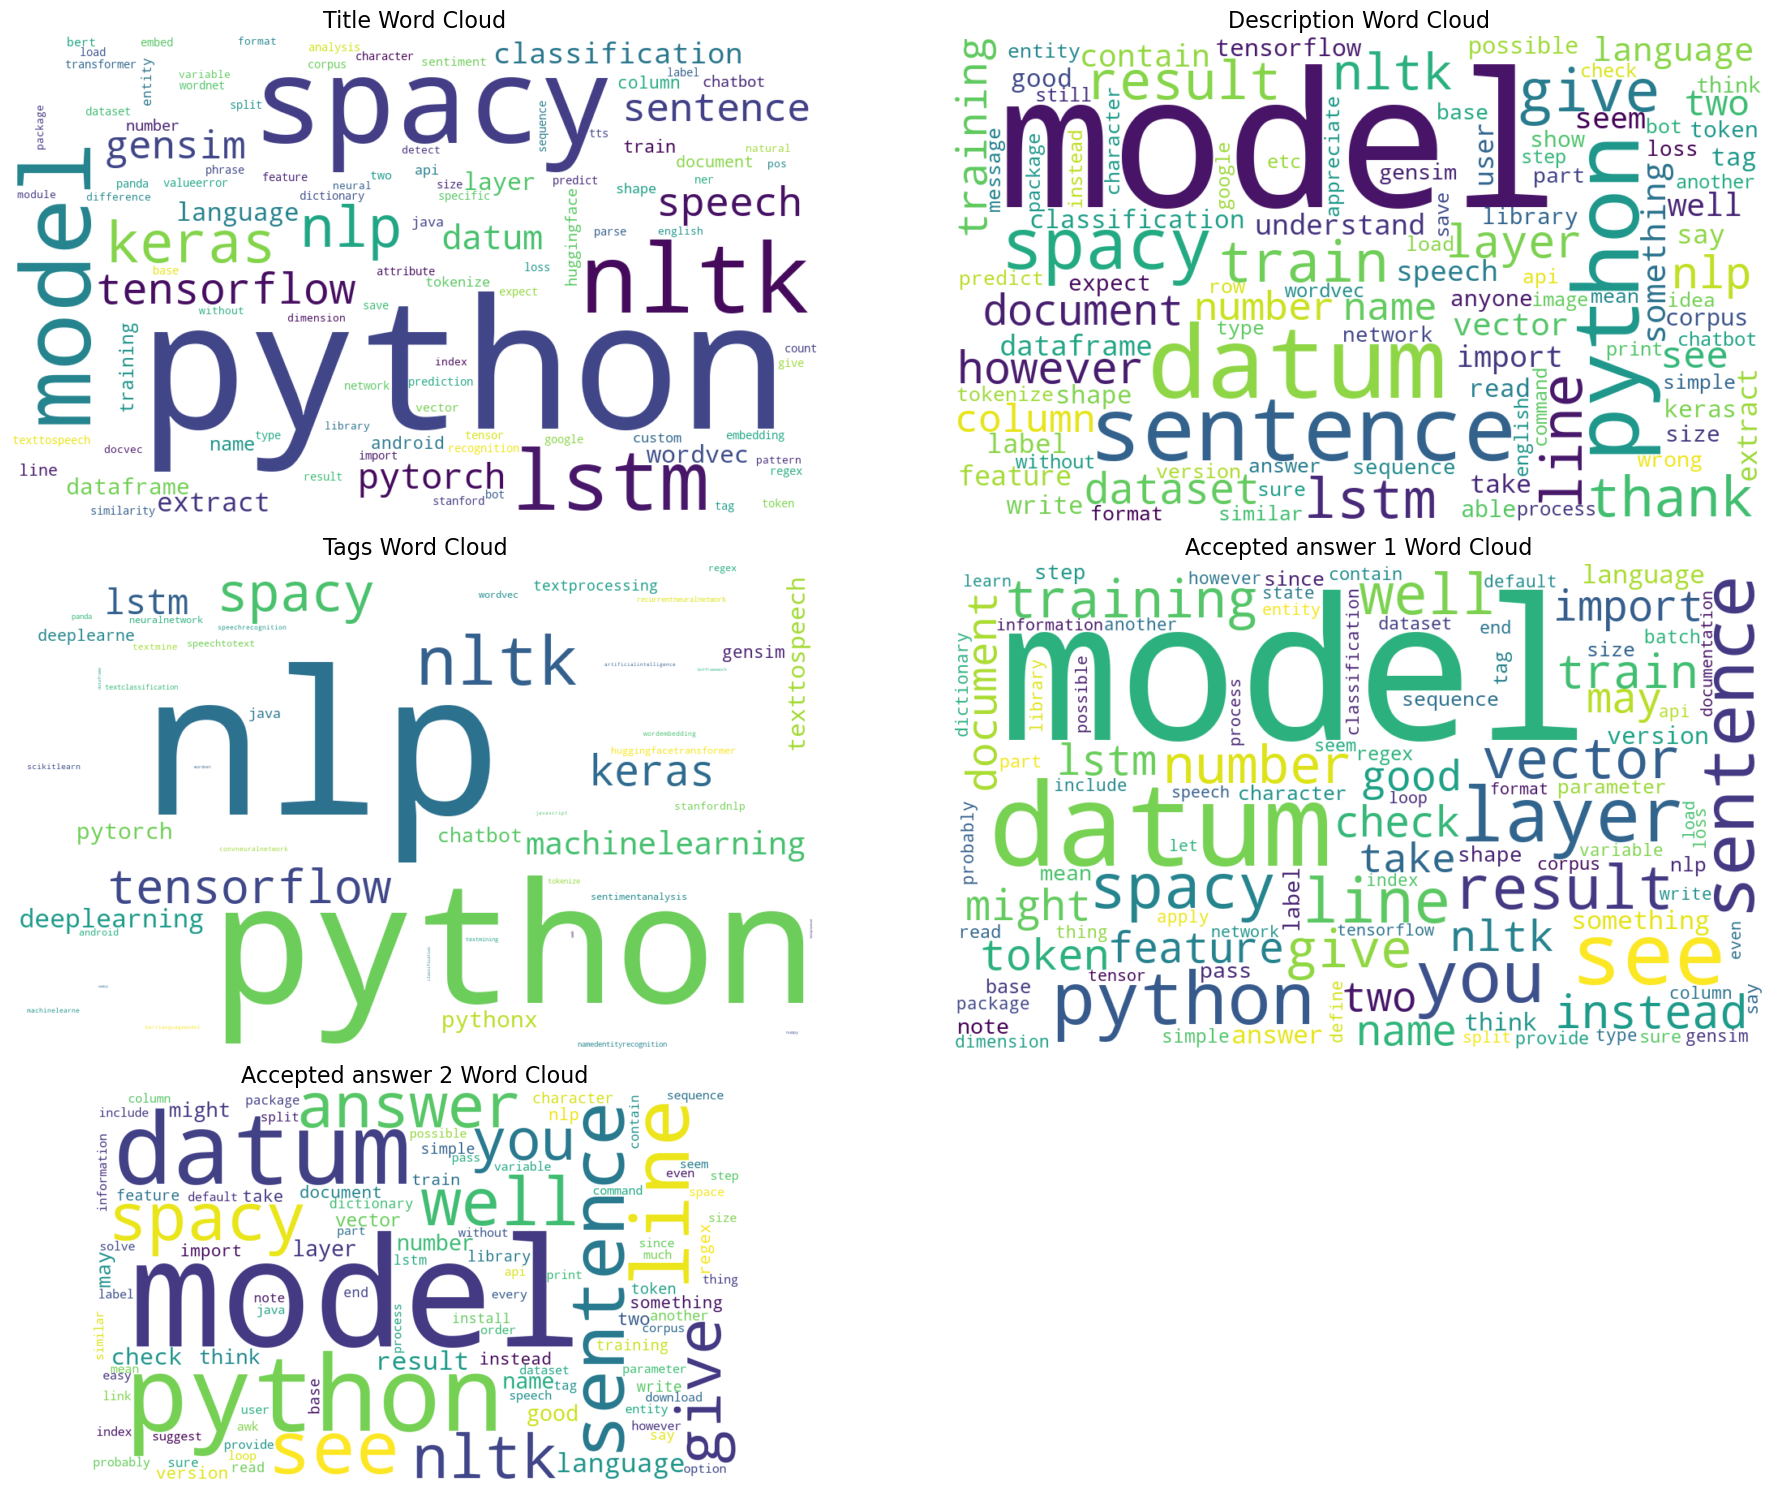

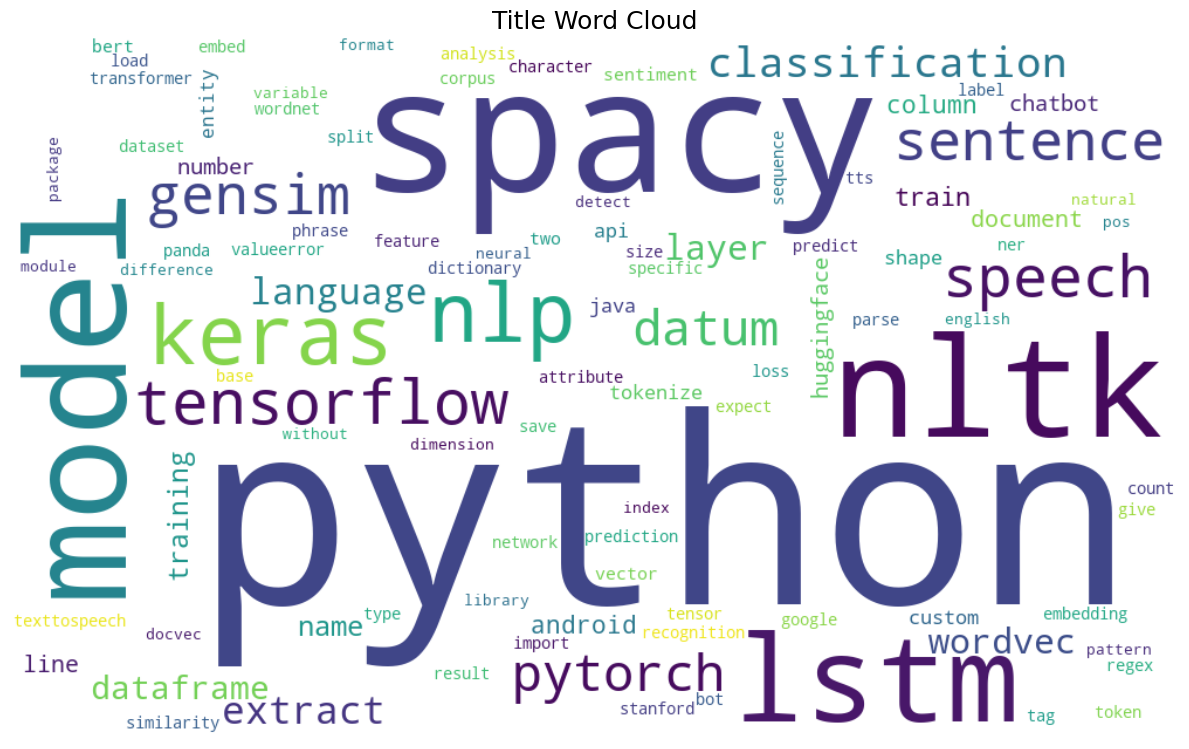

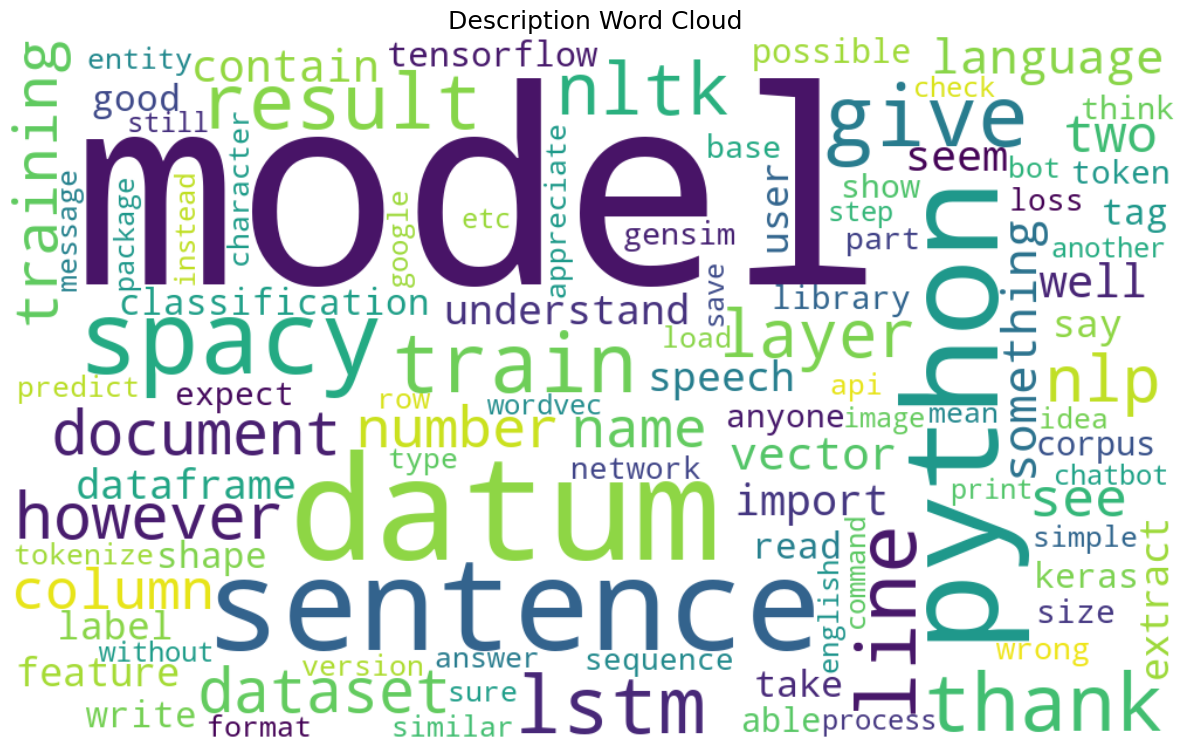

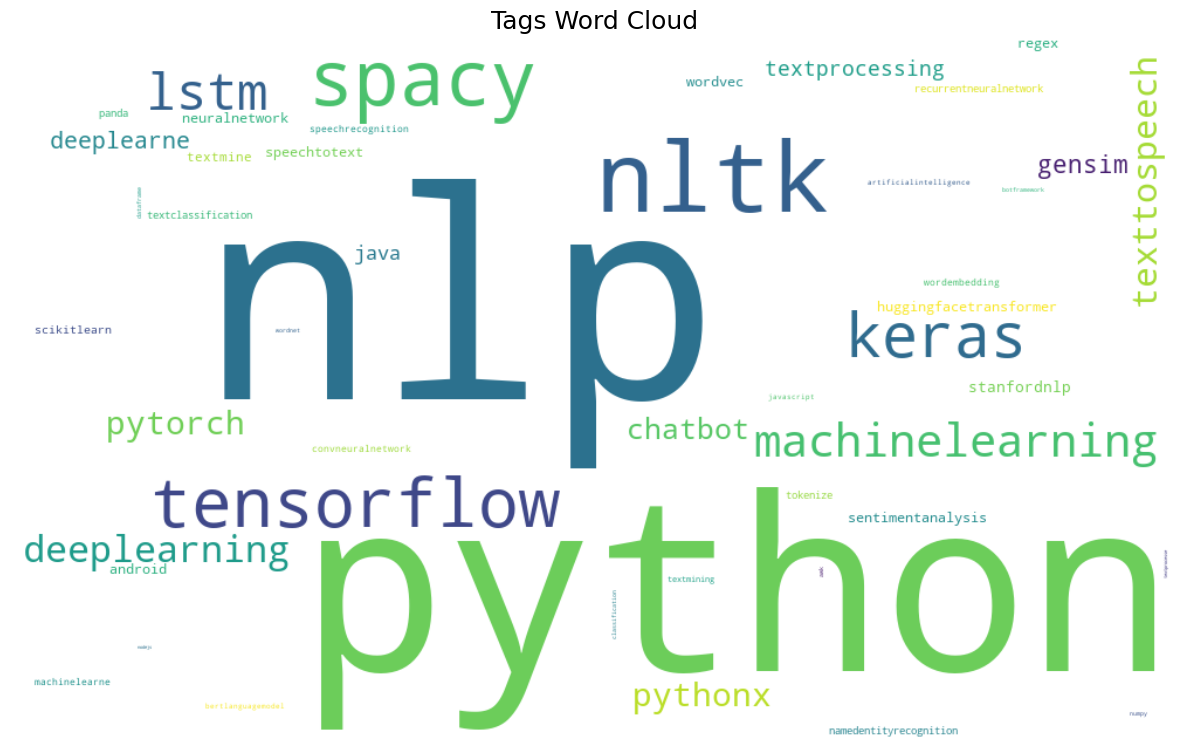

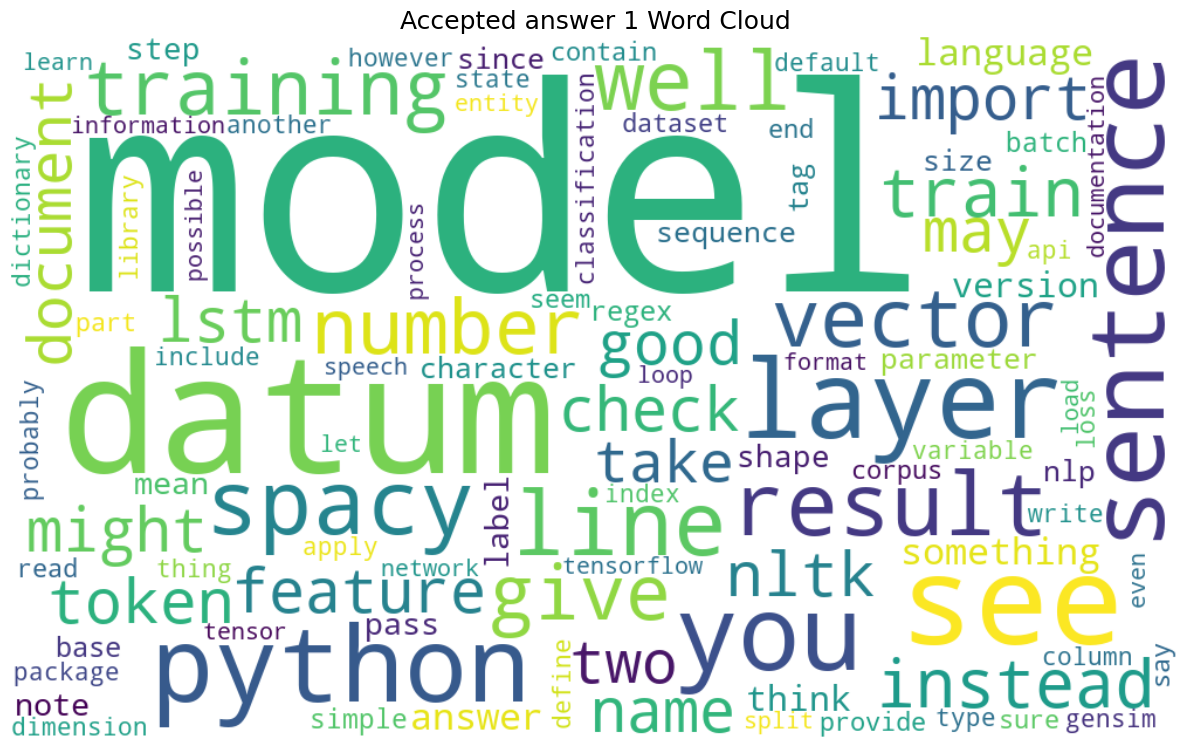

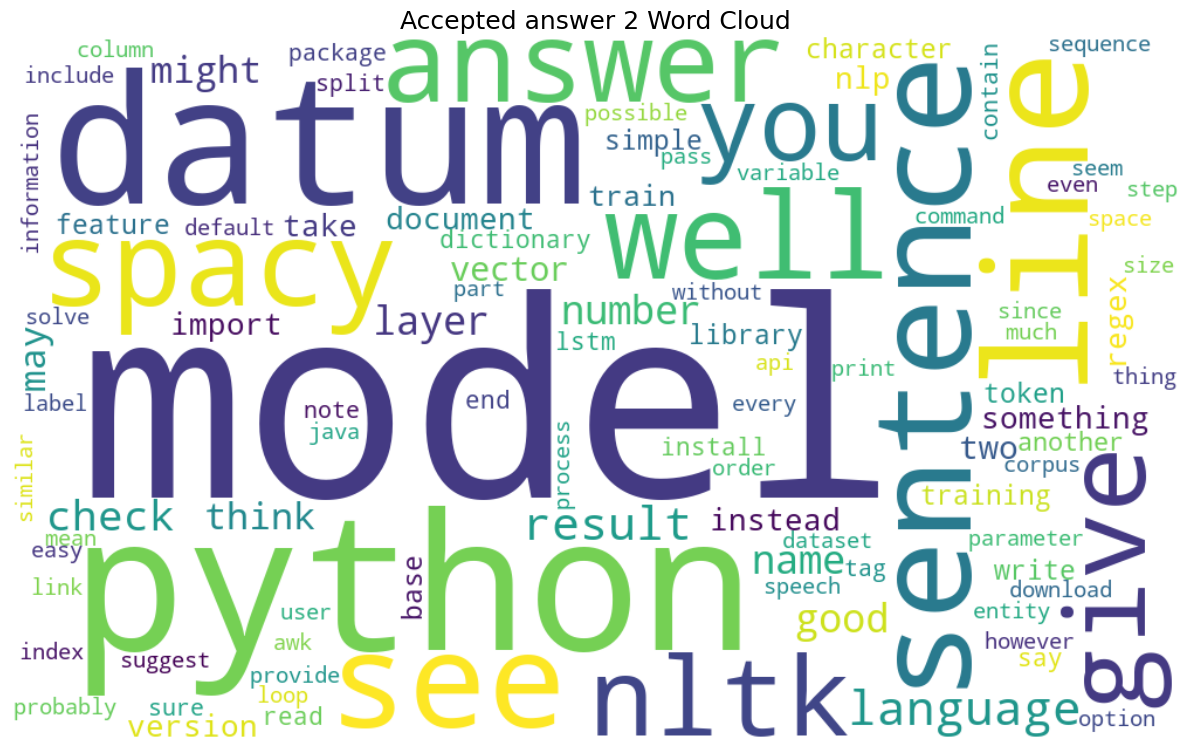

In [81]:
columns = ['title', 'description', 'tags', 'accepted answer 1', 'accepted answer 2']

results = {}
for column in columns:
    print(f"Processing {column}...")
    # token extraction, lemmatization, custom stopword removal, bigram calculation, TF-IDF scoring, tag/keyword boosting, and final score calculation
    wordcloud, top_terms = process_column(processed_data, column)
    if wordcloud:
        results[column] = {'wordcloud': wordcloud, 'top_terms': top_terms}
        print(f"Top 10 terms in {column}:")
        for term, score in top_terms[:10]:
            print(f"  {term}: {score:.2f}")


plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 0.8])

for i, column in enumerate(columns):
    if column in results:
        plt.subplot(gs[i])
        plt.imshow(results[column]['wordcloud'], interpolation='bilinear')
        plt.axis('off')
        plt.title(f'{column.capitalize()} Word Cloud', fontsize=16)

plt.tight_layout()
plt.savefig('nlp_dataset_wordclouds.png', dpi=300)
plt.show()


for column, data in results.items():
    plt.figure(figsize=(12, 8))
    plt.imshow(data['wordcloud'], interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{column.capitalize()} Word Cloud', fontsize=18)
    plt.tight_layout()
    plt.savefig(f'{column.replace(" ", "_")}_wordcloud.png', dpi=300)
    
    # Save top terms to text file
    with open(f'{column.replace(" ", "_")}_top_terms.txt', 'w') as f:
        f.write(f"Top terms in {column}:\n")
        for term, score in data['top_terms']:
            f.write(f"{term}: {score:.2f}\n")

## Step-by-Step Explanation

1. **Lemmatization with spaCy**: The pipeline begins by lemmatizing tokens using spaCy, which handles different word forms better than stemming or basic lemmatization.

2. **Custom Stopword Removal**: Technical and programming-specific stopwords are filtered out after lemmatization to focus on meaningful terms.

3. **N-gram Extraction**: Bigrams are extracted to capture meaningful technical phrases like "machine_learning" or "word_embedding".

4. **TF-IDF Weighting**: Terms are weighted based on their distinctiveness in the corpus, not just their frequency.

5. **Tag Information Leverage**: Terms that appear as tags are given a boost, reflecting their importance in the domain.

6. **Combining Multiple Signals**: The final word cloud weights incorporate:
   - Raw frequency counts (after lemmatization and stopword removal)
   - Bigram importance (weighted higher than unigrams)
   - TF-IDF scores (to highlight distinctive terms)
   - Tag importance (domain expertise)
   - Manually specified boosts for key NLP terms

7. **Word Cloud Generation**: The final visualization uses comprehensive weighting to show truly important terms.

## Advantages of This Approach

1. **More Meaningful Results**: By lemmatizing first, I can group related word forms together, giving a better representation of concept importance.

2. **Cleaner Visualization**: The preprocessing removes programming meta-language and focuses on substantive technical terms.

3. **Technical Context Preserved**: Bigrams capture important technical phrases that would be lost with single-word processing.

4. **Domain Knowledge Integration**: By boosting terms based on tags, I can incorporate subject-matter expertise into the visualization.

5. **Multiple Evidence Sources**: The combination of frequency, TF-IDF, and domain knowledge creates a more robust importance metric.


-------------------------------------
# Insights About the __Title__ column's WordCloud

This word cloud offers valuable insights into the main topics and technologies discussed in the titles of your NLP dataset:

## Dominant Technologies and Frameworks

1. **Python** emerges as the most prominent term, reflecting its status as the primary programming language for NLP applications.

2. **spaCy** appears as one of the largest terms, indicating its popularity as an industrial-strength NLP library.

3. **LSTM** (Long Short-Term Memory) has significant prominence, showing the importance of this neural network architecture in NLP tasks.

4. **NLP** itself is prominently featured, which is expected given the dataset's focus.

5. **TensorFlow** and **PyTorch** both appear, representing the two most popular deep learning frameworks.

6. **NLTK** is clearly visible, showing the continued relevance of this classical NLP library despite newer alternatives.

7. **Gensim** is visible, highlighting its importance for topic modeling and document similarity.

## Key NLP Concepts and Tasks

1. **Word** and **Sentence** are prominent, representing fundamental units of text processing.

2. **Classification** is significant, suggesting many questions involve categorizing text.

3. **Model** indicates a focus on machine learning approaches to NLP.

4. **Language** appears as a medium-sized term, suggesting discussions about multilingual processing or language models.

5. **Extract** points to information extraction as a common task.

6. **Keras** is visible, showing its popularity as a high-level neural network API.

## Technical Details and Components

1. **DataFrame** suggests integration with pandas for data manipulation.

2. **Tokenize** reflects the fundamental NLP preprocessing step.

3. **WordVec** (word vectors/embeddings) shows the importance of word representations.

4. **BERT** is visible, though not as large as expected given its impact on the field, possibly indicating the dataset may not be entirely up-to-date with the latest transformer models.

5. **Training** suggests questions about model development.

## Application Areas

1. **ChatBot** appears, showing interest in conversational AI.

2. **TextToSpeech** is visible, indicating speech synthesis applications.

3. **Sentiment** suggests sentiment analysis is a common task.

4. **NER** (Named Entity Recognition) is present as a specific NLP task.

## Insights About the Community

1. The variety of terms suggests a mix of beginners and more advanced practitioners, with questions ranging from basic (tokenization) to advanced (LSTM implementation).

2. The presence of both traditional tools (NLTK) and modern approaches (BERT, PyTorch) shows a community in transition.

3. The prominence of practical implementation terms (DataFrame, API, Format) suggests a focus on applied NLP rather than theoretical research.

4. The diversity of visible libraries indicates that users are exploring multiple approaches rather than standardizing on a single toolkit.

This word cloud effectively captures the technical ecosystem of NLP as represented in your dataset's titles, highlighting both the core technologies and the typical tasks practitioners are working with.

## __4. Categorisation of the Posts <a class="anchor" id="fourth-bullet"></a>__  
[Table of Contents](#toc)   

### Categorizing NLP Posts from Stack Overflow  
#### __Categorization Strategy Based on Title:__  
1. __Question Types - Based on the intent of the question:__ 
- Implementation questions
- Conceptual/knowledge understanding
- troubleshooting


2. __NLP Tasks - Based on the specific NLP function:__

- Tokenization and preprocessing data
- Text classification
- Named Entity Recognition
- Word embeddings
- Language models


3. __Libraries & Technologies - Based on the technical tools:__

- spaCy library
- NLTK library
- Hugging Face & Transformers



This multi-dimensional categorization allows a post to belong to multiple categories. For example, a question might be both an "Implementation Question" about "Named Entity Recognition" using the "spaCy Library.  


  
-----------------------

In [82]:


#df = pd.read_excel('ques_ans_processed.xlsx')

# Define categories for the NLP posts
categories = {
    # Question types
    "Implementation Questions": [
        r"how\s+to", r"how\s+do", r"how\s+can", r"implement", r"using", r"usage"
    ],
    
    "Conceptual Understanding": [
        r"what\s+is", r"what\s+are", r"meaning", r"explain", r"understand", r"concept"
    ],
    
    "Troubleshooting": [
        r"error", r"issue", r"problem", r"bug", r"not\s+working", r"doesn't\s+work", r"fix"
    ],
    
    # NLP Tasks
    "Tokenization & Preprocessing": [
        r"tokeniz", r"token", r"preprocess", r"clean", r"parse", r"split"
    ],
    
    "Text Classification": [
        r"classif", r"categor", r"sentiment", r"label", r"predict"
    ],
    
    "Named Entity Recognition": [
        r"ner", r"named\s+entity", r"entity\s+recognition", r"extract\s+entity"
    ],
    
    "Word Embeddings": [
        r"embedding", r"word2vec", r"glove", r"fasttext", r"vector", r"representation"
    ],
    
    "Language Models": [
        r"language\s+model", r"bert", r"gpt", r"transformer", r"pretrain", r"finetun"
    ],
    
    # Libraries
    "spaCy Library": [
        r"spacy", r"spacey"
    ],
    
    "NLTK Library": [
        r"nltk", r"natural\s+language\s+toolkit"
    ],
    
    "Hugging Face & Transformers": [
        r"huggingface", r"hugging\s+face", r"transformers"
    ]
}


In [83]:
# Compile all regex patterns
compiled_categories = {}
for category, patterns in categories.items():
    compiled_patterns = [re.compile(pattern, re.IGNORECASE) for pattern in patterns]
    compiled_categories[category] = compiled_patterns
print("Compiled categories:", compiled_categories)

Compiled categories: {'Implementation Questions': [re.compile('how\\s+to', re.IGNORECASE), re.compile('how\\s+do', re.IGNORECASE), re.compile('how\\s+can', re.IGNORECASE), re.compile('implement', re.IGNORECASE), re.compile('using', re.IGNORECASE), re.compile('usage', re.IGNORECASE)], 'Conceptual Understanding': [re.compile('what\\s+is', re.IGNORECASE), re.compile('what\\s+are', re.IGNORECASE), re.compile('meaning', re.IGNORECASE), re.compile('explain', re.IGNORECASE), re.compile('understand', re.IGNORECASE), re.compile('concept', re.IGNORECASE)], 'Troubleshooting': [re.compile('error', re.IGNORECASE), re.compile('issue', re.IGNORECASE), re.compile('problem', re.IGNORECASE), re.compile('bug', re.IGNORECASE), re.compile('not\\s+working', re.IGNORECASE), re.compile("doesn't\\s+work", re.IGNORECASE), re.compile('fix', re.IGNORECASE)], 'Tokenization & Preprocessing': [re.compile('tokeniz', re.IGNORECASE), re.compile('token', re.IGNORECASE), re.compile('preprocess', re.IGNORECASE), re.compil

In [84]:

# Function to categorize a post based on its title
def categorize_post(title):
    if not isinstance(title, str):
        return []
    
    matching_categories = []
    for category, patterns in compiled_categories.items():
        for pattern in patterns:
            if pattern.search(title):
                matching_categories.append(category)
                break  # No need to check other patterns for this category, move to the next category (one question can be classified into multiple categories)
    return matching_categories


This block of code down below automates the process of categorizing posts according to their titles using a predefined function, analyzes the distribution and overlap of these categories, and exports the categorized data into separate files.

**Workflow:**

1.  **Initialization:**
    * `post_categories` is used to store lists of posts associated with each category key.
    * `categorized_posts` is initialized to keep track of the unique IDs of posts that have been assigned at least one category.

2.  **Categorization Loop:**
    * Iterates through each row of the input dataset.
    *  `categorize_post()` is expected to return a list of applicable category names based on the title's content.

3.  **Overlap Analysis:**
    * Calculates how often posts are assigned to multiple categories simultaneously.
    * Identifies pairs of categories that frequently co-occur for the same post.
    * Prints the top 10 most common category pairs and their co-occurrence counts.


In [88]:
# Categorize all posts
post_categories = defaultdict(list) #store all posts' categories using categories as KEY of this dictionary
categorized_posts = set()  # Track unique post IDs that have been categorized

# Process each post (limit to first 1000 for demonstration)
for idx, row in processed_data.iterrows(): #.head(1000)
    categories = categorize_post(row.get('title', ''))
    if categories:
        for category in categories:
            post_categories[category].append({
                'id': row['question_id'],
                'title': row.get('title', ''),
                'tags': row.get('tags', ''),
                'answer': row.get('accepted answer 1', '')
            })
        categorized_posts.add(row['question_id'])

# Print category statistics
print("\nCategory Distribution:")
print("-" * 50)
for category, posts in post_categories.items():
    print(f"{category}: {len(posts)} posts")

# Print examples from each category
print("\nExamples from Each Category:")
print("-" * 50)
for category, posts in post_categories.items():
    print(f"\n{category} ({len(posts)} posts):")
    # Show up to 5 examples of each category
    for i, post in enumerate(posts[:5]):
        print(f"  {i+1}. {post['title']}")

# Calculate total categorized posts
print(f"\nTotal unique posts categorized: {len(categorized_posts)} out of 24774 posts")

# Analysis of overlap between categories
category_overlap = defaultdict(int)
for idx in categorized_posts:
    # Find all categories this post belongs to
    post_cats = []
    for category, posts in post_categories.items():
        if any(post['id'] == idx for post in posts):
            post_cats.append(category)
    
    # If post belongs to multiple categories, record the category pairs
    if len(post_cats) > 1:
        for i in range(len(post_cats)):
            for j in range(i+1, len(post_cats)):
                pair = tuple(sorted([post_cats[i], post_cats[j]]))
                category_overlap[pair] += 1

# Print top category overlaps
print("\nTop Category Overlaps:")
print("-" * 50)
top_overlaps = sorted(category_overlap.items(), key=lambda x: x[1], reverse=True)
for (cat1, cat2), count in top_overlaps[:10]:
    print(f"{cat1} + {cat2}: {count} posts")

# Save categorized posts to CSV files
for category, posts in post_categories.items():
    # Create a DataFrame with all posts in this category
    category_df = pd.DataFrame(posts)
    
    #Save to CSV
    safe_category_name = category.replace(' ', '_').replace('&', 'and')
    category_df.to_csv(f"title_categorizations/{safe_category_name}_posts.csv", index=False)
    
    print(f"Would save {len(posts)} posts to {category.replace(' ', '_').replace('&', 'and')}_posts.csv")

print("\nCategorization completed successfully!")


Category Distribution:
--------------------------------------------------
Named Entity Recognition: 1029 posts
Word Embeddings: 1151 posts
Language Models: 1030 posts
Implementation Questions: 7606 posts
Hugging Face & Transformers: 551 posts
Troubleshooting: 3030 posts
Text Classification: 2156 posts
Tokenization & Preprocessing: 1723 posts
spaCy Library: 1264 posts
Conceptual Understanding: 711 posts
NLTK Library: 1549 posts

Examples from Each Category:
--------------------------------------------------

Named Entity Recognition (1029 posts):
  1. opennlp postaggerme and chunkerme synergy
  2. how to get custom column in the models forward function when training with huggingface trainer
  3. llamabinstruct generate inconsistent output
  4. how to derive attributeslabels from short plain text descriptions ner llm
  5. seqseq trainertrain keeps giving indexing error

Word Embeddings (1151 posts):
  1. underfitting pretrained glove lstm model accurcacy unchanged
  2. euclidian distanc

# Analysis of NLP Stack Overflow Post Categorization

## Category Distribution Overview

The categorization has successfully classified 15,267 unique posts (61.6% of the total 24,774 posts, because unlabeled posts could not matcha the regex regression) into 11 distinct categories. Here's what the distribution reveals:

### Primary categories by occurences

1. **Implementation Questions (7,606 posts)** - By far the largest category, representing nearly half of all categorized posts. This indicates that developers primarily use Stack Overflow for practical "how-to" guidance rather than conceptual understanding.

2. **Troubleshooting (3,030 posts)** - The second largest category, showing that error resolution is a significant challenge in NLP development.

3. **Text Classification (2,156 posts)** - This represents the most commonly discussed specific NLP task, highlighting its importance in practical applications.

### Technical focus areas

- **Libraries**: NLTK (1,549) and spaCy (1,264) have significant representation, with NLTK showing slightly more questions despite spaCy's more modern architecture.

- **Task-specific Categories**: Text Classification (2,156), Tokenization & Preprocessing (1,723), Word Embeddings (1,151), and Named Entity Recognition (1,029) all have substantial representation, reflecting their importance in NLP workflows.

- **Modern Technologies**: Language Models (1,030) and Hugging Face & Transformers (551) have fewer questions, possibly because they're newer technologies or because their documentation is more comprehensive.

### Notable observations

- **Conceptual Understanding (711)** is the smallest category, reinforcing that Stack Overflow is primarily used for practical implementation assistance rather than theoretical questions.

- The combined count of all categories (21,800) far exceeds the unique categorized posts count (15,267), showing that many posts belong to multiple categories.

## Category Overlaps and Relationships

The category overlap data provides valuable insights into how different NLP aspects relate to each other:

### Strongest Relationships

1. **Implementation Questions + Text Classification (736 posts)** - Indicates that implementing classification systems is a common challenge.

2. **Implementation Questions + Tokenization & Preprocessing (578 posts)** - Shows that text preprocessing remains a fundamental implementation challenge.

3. **Implementation Questions + NLTK Library (530 posts)** - Suggests NLTK has a steeper learning curve or more complex implementation details than other libraries.

### Technical Patterns

- **Implementation overlaps with everything** - The "how to" questions cut across all technical categories, which is expected.

- **Hugging Face & Transformers + Language Models (315 posts)** - Shows the close relationship between these technologies, as Hugging Face is primarily used for transformer-based language models.

- **Text Classification + Troubleshooting (253 posts)** - Indicates that text classification implementations often encounter errors requiring troubleshooting.

## Examples Analysis

Looking at the example posts from each category:

1. **Implementation Questions** show a focus on practical integration issues:
   - "How to get custom column in the models forward function when training with huggingface trainer"
   - "How can I share a complex spacy nlp model across multiple python processes"

2. **Troubleshooting** examples reveal common error patterns:
   - "Error in getting captum text explanations for text classification"
   - "Trainer huggingface runtimeerror cannot pin torchcudafloattensor"

3. **Text Classification** examples show diverse applications:
   - "Dutch sentiment analysis robbertje outputs just positivenegative labels"
   - "Capitalized words in sentiment analysis"




This categorization provides an excellent foundation for building a comprehensive knowledge base of NLP challenges and solutions that would be valuable for anyone starting with NLP development.

### __**Categorize based on Title + Description**__  
##### This implementation follows the hybrid approach:
##### 1. Used LDA to discover initial topics (unsupervised)
##### 2. Reviewed topics and refined them into meaningful categories 
##### 3. Created a small training set by manually labeling sentences 
##### 4. Trained a simple classifier (SVM with TF-IDF features)
##### 5. Applied the classifier to categorize all sentences in the dataset
##### 6. Extracted representative examples 

In [ ]:
# Process each post to extract sentences
all_sentences = []
sentence_to_post = {}

for _, row in processed_data.iterrows():
    # Extract sentences from title and description
    title_tokens = ' '.join([token for token in row['title_tokens'] ])
    # title_sentences = extract_sentences(title_tokens)
    title_sentences = [title_tokens]
    desc_tokens = ' '.join([token for token in row['description_tokens'] ])
    # desc_sentences = extract_sentences(desc_tokens)
    desc_sentences = [desc_tokens]
    
    ## Categorize based on post content/post combining with title content
    # post_sentences = title_sentences + desc_sentences #title_sentences + 
    sentence = ' '.join([title_tokens, desc_tokens]) #concat title and description
    
    # for sentence in post_sentences:
    if len(sentence.split()) < 3:  # Skip very short sentences
        continue
        
    all_sentences.append(sentence)
    sentence_to_post[sentence] = {
        'question_id': row['question_id'],
        'source': 'title + desc' #'title' if sentence in title_sentences else 'description'
    }

print(f"Total sentences extracted: {len(all_sentences)}")

Total sentences extracted: 24774


In [430]:
# Apply LDA to discover initial topics

# Create document-term matrix using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.5,     # Ignore terms that appear in >50% of documents
    min_df=5,       # Ignore terms that appear in fewer than 5 documents
    stop_words='english',
    ngram_range=(1, 2)  # Consider both unigrams and bigrams for better topics
)
doc_term_matrix = tfidf_vectorizer.fit_transform(all_sentences)

models = {}
# Apply LDA - I experiment different number of components from 3->6
for n in range(1,6):
    print("LDA n_components =", n+1)
    n_topics = n+1
    lda_model = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42,
        learning_method='online'
    )
    lda_model.fit(doc_term_matrix)
    models[n_topics] = lda_model


LDA n_components = 2
LDA n_components = 3
LDA n_components = 4
LDA n_components = 5
LDA n_components = 6


In [431]:

for n_topics, lda_model in models.items(): # loop through all lda model in the cell above to see how the key words of each category looks like based on hyper param n_components
    print(f"\n------ LDA model with {n_topics} component: -----")
    # Get topic for each sentence
    sentence_topics = lda_model.transform(doc_term_matrix) #Each row contains probabilities for each topic
    sentence_primary_topics = sentence_topics.argmax(axis=1)

    # Display top words for each topic to understand what they represent
    feature_names = tfidf_vectorizer.get_feature_names_out()

    print("Dominant keywords:")
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words_idx = topic.argsort()[:-20 - 1:-1]  # Get indices of top 10 words
        top_words = [feature_names[i] for i in top_words_idx]
        print(f"Topic #{topic_idx+1}: {' '.join(top_words)}")
        


------ LDA model with 2 component: -----
Dominant keywords:
Topic #1: word text file like sentence list want speech code work python try string nltk way line example language need column
Topic #2: model error layer lstm train input code try datum training dataset output follow shape keras vector run tensorflow network loss

------ LDA model with 3 component: -----
Dominant keywords:
Topic #1: model layer lstm input error train shape training keras datum tensorflow network loss output code dataset image pytorch try size
Topic #2: word text file like sentence want list code try python way example line string work need output document follow know
Topic #3: speech bot error voice tts app api audio run android google text speech message chatbot instal texttospeech install work try import

------ LDA model with 4 component: -----
Dominant keywords:
Topic #1: noun stanford pos verb tree dependency tagger parser corenlp pos tag tag use stanford adjective parse stanford corenlp stanford nlp po

__At this point, we have to choose the hyperparam n_components (number of clusters(types) of questions we want to categorize posts into) for this task, based on the following factors:__
* The distribution of number of posts among all the categories (the dataset should not be too imbalanced)  
* Based on the common partterns of each top keywords foreach topic above (whether it makes sense to make it a seperate category?)
* Keep the dataset diverse, as many categories as possible, as it provides a more granular view of different question types

In [ ]:
categories = ['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4','Topic 5','Topic 6'] # we have at most 6 topics
#code to print out number of every topic wrt a corresponding n_components
for n_topics in range(2, 7):

#n_topics = 3
    # Map LDA topics to categories
    topic_to_category = {i: categories[i] for i in range(n_topics)}
    # print("Defined categories:")
    # for i, category in topic_to_category.items():
    #     print(f"  Topic {i+1} -> {category}")
    
    lda_model= models[n_topics] #models[3] has n_component = 3
    print(f"\n------ LDA model with {n_topics} components: -----")
    # Get topic for each sentence
    sentence_topics = lda_model.transform(doc_term_matrix) #Each row contains probabilities for each topic
    #get the topic of highest prob for each row
    sentence_primary_topics = sentence_topics.argmax(axis=1)

    # use LDA assignments to create an initial labeled dataset
    training_data = []
    for i, sentence in enumerate(all_sentences):

        lda_topic = sentence_primary_topics[i]
        category = topic_to_category[lda_topic]
        
        training_data.append({
            'sentence': sentence,
            'category': category
        })
    print(pd.DataFrame(training_data)['category'].value_counts())



------ LDA model with 2 components: -----
category
Topic 1    15202
Topic 2     9572
Name: count, dtype: int64

------ LDA model with 3 components: -----
category
Topic 2    15480
Topic 1     6104
Topic 3     3190
Name: count, dtype: int64

------ LDA model with 4 components: -----
category
Topic 4    19097
Topic 2     4738
Topic 3      853
Topic 1       86
Name: count, dtype: int64

------ LDA model with 5 components: -----
category
Topic 4    24438
Topic 1      203
Topic 3      105
Topic 2       28
Name: count, dtype: int64

------ LDA model with 6 components: -----
category
Topic 2    24440
Topic 5      330
Topic 6        2
Topic 1        1
Topic 3        1
Name: count, dtype: int64


After analysing the ratio between categories corresponding to a specific n_components, we came up with this table:
| Components | Dominant Topic                                  | Spread of Counts       |
|------------|--------------------------------------------------|-------------------------|
| 2          | One topic dominates (15k vs 9.5k)                | Skewed                  |
| 3          | Balanced: 15k, 6k, 3k                            | Decent spread           |
| 4          | One topic dominates (19k), others drop           | Skewed again            |
| 5          | One topic completely dominates (24k)             | Others <300             |
| 6          | One topic still dominates, others are almost noise | Extreme skew         |  
  
Here we can see that n_components = 3 is a reasonable choice, because of the following reasons:
- __Good balance of distribution:__
    - Topic 2: 15,480  
    - Topic 1: 6,104  
    - Topic 3: 3,190  
This shows each topic has enough representations to be meaningful, but not too much so that one topic completely overshadows the others.

- __Interpretability:__
With 3 topics, we are more likely to obtain consistent themes in our data without drowning in fine-grained noise or overly general clusters.

- __Avoiding Overfitting:__
More topics can start fitting to random noise or complex patterns that do not generalize. Given results with 5 and 6 topics show that most topics get only a handful of documents.



#### __Named categories:__  
looking back at the top keywords for each topic with respect to n_components = 3:  
__Dominant keywords:__  
- Topic #1: model layer lstm input error train shape training keras datum tensorflow network loss output code dataset image pytorch try size  
    These are strongly related to model architecture, training neural networks, and deep learning libraries.  
  => Name topic #1 as __"Deep Learning & Model Training"__
- Topic #2: word text file like sentence want list code try python way example line string work need output document follow know    
    This seems to cover general-purpose scripting, text/file handling, and Python code.  
    => Name topic #2 as __"Python Scripting & Text Handling"__
- Topic #3: speech bot error voice tts app api audio run android google text speech message chatbot instal texttospeech install work try import  
    These words focused on voice interfaces, text-to-speech, and chatbot development.  
    => Name topic #3 as __"Speech Processing & Chatbots"__


In [467]:
# change categories list back to 3 categories with the names mentioned above
categories = ["Deep Learning & Model Training", "Python Scripting & Text Handling", "Speech Processing & Chatbots"] 
n_topics = 3
# # Map LDA topics to categories
topic_to_category = {i: categories[i] for i in range(n_topics)}
category_to_topic = {categories[i]:i for i in range(n_topics)}
print("Defined categories:")
for i, category in topic_to_category.items():
    print(f"  Topic {i+1} -> {category}")
# out current model
lda_model= models[n_topics] 


Defined categories:
  Topic 1 -> Deep Learning & Model Training
  Topic 2 -> Python Scripting & Text Handling
  Topic 3 -> Speech Processing & Chatbots


In [453]:
# Get topic for each sentence
sentence_topics = lda_model.transform(doc_term_matrix) #Each row contains probabilities for each topic
#get the topic of highest prob for each row
sentence_primary_topics = sentence_topics.argmax(axis=1)

__Create a training dataset__

In [455]:
# Create a training dataset

# use LDA assignments to create an initial labeled dataset
training_data = []
for i, sentence in enumerate(all_sentences):
    # get LDA topic (0,1,2)
    lda_topic = sentence_primary_topics[i]
    # get category name (from lda topic)
    category = topic_to_category[lda_topic]
    
    training_data.append({
        'sentence': sentence,
        'category': category
    })
pd.DataFrame(training_data)['category'].value_counts()

category
Python Scripting & Text Handling    15480
Deep Learning & Model Training       6104
Speech Processing & Chatbots         3190
Name: count, dtype: int64

In [ ]:
# get a small subset including 100 samples to be the training data (for SVC model)
training_size = min(100, len(training_data))
training_subset = random.sample(training_data, training_size)

labeled_df = pd.DataFrame(training_subset)

print(f"Training data size: {len(labeled_df)} sentences")
print("Category distribution in training data:")
print(labeled_df['category'].value_counts())


Training data size: 100 sentences
Category distribution in training data:
category
Python Scripting & Text Handling    55
Deep Learning & Model Training      28
Speech Processing & Chatbots        17
Name: count, dtype: int64


In [457]:
# training dataset
labeled_df

sentence  \
0   train lstm network predict different starting ...   
1   search phrase text pos tagging want extract ph...   
2   keras embadde sentence array input new keras t...   
3   google mean algorithm work develop internal we...   
4   keras lstm translation model wrong prediction ...   
..                                                ...   
95  nltk download ssl certificate verify fail get ...   
96  could use bahdanau attention stack lstm model ...   
97  multiple ngram transition matrix probability a...   
98  sentiment analysis use azure cognitive service...   
99  extract topic exist text cluster perform hard ...   

                            category  
0     Deep Learning & Model Training  
1   Python Scripting & Text Handling  
2     Deep Learning & Model Training  
3   Python Scripting & Text Handling  
4     Deep Learning & Model Training  
..                               ...  
95      Speech Processing & Chatbots  
96    Deep Learning & Model Training  
97  Python Scripting & Text Handling  
98      Speech Processing & Chatbots  
99  Python Scripting & Text Handling  

[100 rows x 2 columns]

__train data using LinearSVC__

In [458]:
# Train a classifier on the manually labeled data
X_train = labeled_df['sentence']
y_train = labeled_df['category']

# Create a pipeline with TF-IDF and SVM
classifier = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', LinearSVC())
])
# Train the classifier
classifier.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf', LinearSVC())])

In [469]:
# Apply the classifier to all sentences
all_sentences_df = pd.DataFrame({'sentence': all_sentences})
predicted_categories = classifier.predict(all_sentences_df['sentence'])

# Create a results dataframe with all the information
results_df = pd.DataFrame({
    'sentence': all_sentences,
    'predicted_category': predicted_categories,
    'lda_topic': sentence_primary_topics,

})
results_df['lda_category'] = results_df['lda_topic'].map(topic_to_category)
results_df['predicted_topic'] = results_df['predicted_category'].map(category_to_topic)
# rearrange columns of results dataframe
results_df = results_df[['sentence', 'predicted_category', 'lda_category','predicted_topic','lda_topic' ]]
results_df

sentence  \
0      trouble getting import gensim work colab try i...   
1      store image instead show server run code find ...   
2      presidio langchain experimental detect polish ...   
3      opennlp postaggerme chunkerme synergy try use ...   
4      word sentence similarity try find give word se...   
...                                                  ...   
24769  train test split splitting correctly still beg...   
24770  multinomialnb gaussiannb categoricalnb use let...   
24771  custom small cnn well accuracy pretrained clas...   
24772  create dataset image object detection extremel...   
24773  object detection rgbd image please recommend p...   

                     predicted_category                      lda_category  \
0        Deep Learning & Model Training      Speech Processing & Chatbots   
1      Python Scripting & Text Handling      Speech Processing & Chatbots   
2      Python Scripting & Text Handling  Python Scripting & Text Handling   
3      Python Scripting & Text Handling  Python Scripting & Text Handling   
4      Python Scripting & Text Handling  Python Scripting & Text Handling   
...                                 ...                               ...   
24769    Deep Learning & Model Training    Deep Learning & Model Training   
24770  Python Scripting & Text Handling  Python Scripting & Text Handling   
24771    Deep Learning & Model Training    Deep Learning & Model Training   
24772  Python Scripting & Text Handling    Deep Learning & Model Training   
24773  Python Scripting & Text Handling    Deep Learning & Model Training   

       predicted_topic  lda_topic  
0                    0          2  
1                    1          2  
2                    1          1  
3                    1          1  
4                    1          1  
...                ...        ...  
24769                0          0  
24770                1          1  
24771                0          0  
24772                1          0  
24773                1          0  

[24774 rows x 5 columns]

              precision    recall  f1-score   support

           0       0.89      0.79      0.83      6104
           1       0.83      0.95      0.89     15480
           2       0.85      0.45      0.59      3190

    accuracy                           0.85     24774
   macro avg       0.86      0.73      0.77     24774
weighted avg       0.85      0.85      0.84     24774



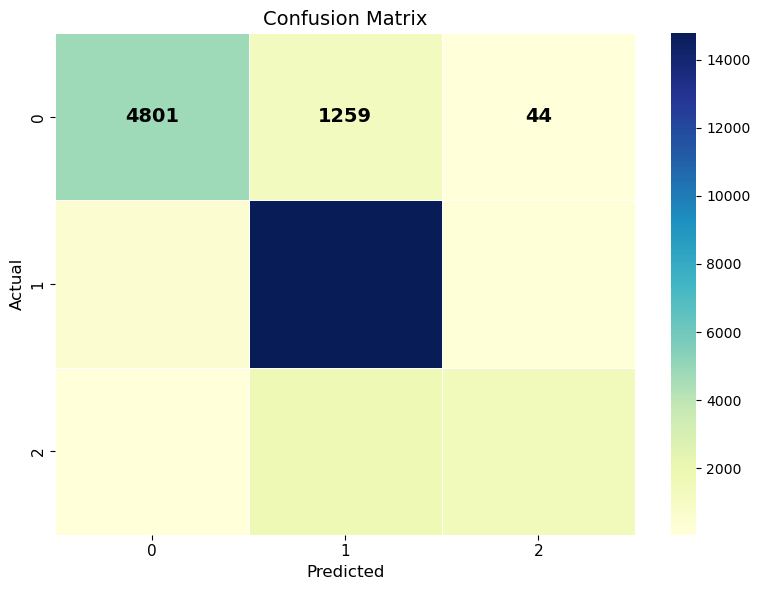

In [478]:
# print classification report
print(classification_report(results_df['lda_topic'], results_df['predicted_topic']))

#confusion matrix
cm = confusion_matrix(results_df['lda_topic'], results_df['predicted_topic'])

plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', cbar=True, linewidths=0.5,
                 annot_kws={"size": 14, "weight": "bold", "color": "black"})  

plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()




In [ ]:
# accuracy per topic
topic_accuracy = results_df.groupby('lda_topic').apply(lambda x: (x['lda_topic'] == x['predicted_topic']).mean())
print(topic_accuracy)


lda_topic
0    0.786533
1    0.954651
2    0.447962
dtype: float64


In [480]:
# Add post information
for i, sentence in enumerate(results_df['sentence']):
    post_info = sentence_to_post[sentence]
    results_df.at[i, 'question_id'] = post_info['question_id']
    results_df.at[i, 'source'] = post_info['source']


In [481]:
print("\n--- CLASSIFICATION RESULTS ---")
print("Category distribution after classification:")
print(results_df['predicted_category'].value_counts())


--- CLASSIFICATION RESULTS ---
Category distribution after classification:
predicted_category
Python Scripting & Text Handling    17699
Deep Learning & Model Training       5399
Speech Processing & Chatbots         1676
Name: count, dtype: int64


1. **Overall Performance**: The model has an overall accuracy of 0.85 (85%) with 24,774 samples.

2. **Class Performance**:
   - Class 0: Precision 0.89, Recall 0.79, F1-score 0.83 (6,104 samples)
   - Class 1: Precision 0.83, Recall 0.95, F1-score 0.89 (15,480 samples) - strongest performing class
   - Class 2: Precision 0.85, Recall 0.45, F1-score 0.59 (3,190 samples) - weakest performing class

3. **Class Imbalance**: There's significant class imbalance with Class 1 having the most samples (15,480), followed by Class 0 (6,104) and Class 2 (3,190).

4. **Confusion Matrix Analysis**:
   - Class 0 is most commonly misclassified as Class 1 (1,259 samples)
   - Class 2 has the lowest recall (0.45), indicating that it's frequently misclassified
   - Class 1 is well classified

5. **Topic Accuracy**: The additional analysis shows accuracy per topic:
   - Topic 0: 0.786533 (78.7%)
   - Topic 1: 0.954651 (95.5%) - highest topic accuracy
   - Topic 2: 0.447962 (44.8%) - lowest topic accuracy

The main issue with this model is the poor performance on Class 2/Topic 2, which has both low recall (0.45) and topic accuracy (44.8%). This suggests the model struggles to correctly identify instances of this class. 

In [488]:
# Extract representative examples for each category
# For each category, get top 3 examples
examples = defaultdict(list)

for category in categories:
    # Get examples for this category
    category_sentences = results_df[results_df['predicted_category'] == category]
    
    # If we have sentences in this category
    if len(category_sentences) > 0:
        # Take up to 3 examples
        for _, row in category_sentences.head(3).iterrows():
            question_id = row['question_id']
            sentence = row['sentence']
            
            # Get the full post info
            post_info = processed_data[processed_data['question_id'] == question_id].iloc[0]
            question_id = int(question_id)
            examples[category].append({
                'question_id': question_id,
                'sentence': sentence,
                'title': post_info['title'],
                'stack_overflow_link': f"https://stackoverflow.com/questions/{question_id}",
                "creation_date" : post_info['creation date']
            })

In [ ]:
# Print examples for each category
print("\n--- Examples foreach category ---")
for category, posts in examples.items():
    print(f"\n## {category}:")
    for i, post in enumerate(posts, 1):
        print(f"  {i}. \"{post['sentence']}\"")
        print(f"     Title: \"{post['title']}\"")
        print(f"     Question ID: {post['question_id']}")
        print(f"     Link: {post['stack_overflow_link']}")
        print()


--- Examples foreach category ---

## Deep Learning & Model Training:
  1. "trouble getting import gensim work colab try import gensim colab get follow error numpy version downgrade numpy another version like say get different error always numpy string relate issue thank"
     Title: "trouble getting importing gensim to work in colab"
     Question ID: 79523269
     Link: https://stackoverflow.com/questions/79523269

  2. "underfitte pretraine glove lstm model accurcacy unchanged sentiment classification use pretraine glove lstm model use google play review scrap result text implement random sampling minority class however train lstm model training accuracy remain unchanged several epoch need insight fix issue several information dataset embed size maximum sequence length label distribution random sampling positive negative neutral label distribution random sampling positive negative neutral total training set pad total validation set pad total testing set pad total training set one h

In [490]:
# Determine primary category for each post
post_category_counts = defaultdict(lambda: defaultdict(int))

for _, row in results_df.iterrows():
    question_id = row['question_id']
    category = row['predicted_category']
    post_category_counts[question_id][category] += 1


In [495]:
# Assign predicted category to each post based on majority of its sentences
post_predicted_categories = {}

for question_id, categories_count in post_category_counts.items():
    # Find category with most sentences
    predicted_category = max(categories_count.items(), key=lambda x: x[1])[0]
    post_predicted_categories[question_id] = predicted_category

# Add predicted category to original dataframe
processed_data['predicted_category'] = processed_data['question_id'].map(post_predicted_categories)

# Final analysis of posts by category
print("\n--- POSTS BY predicted CATEGORY ---")
for category in categories:
    category_posts = processed_data[processed_data['predicted_category'] == category]
    if len(category_posts) > 0:
        print(f"\n{category}: {len(category_posts)} posts")
        for _, post in category_posts.iterrows():
            print(f"  - {post['title']} (ID: {post['question_id']})")
            print(f"    Link: https://stackoverflow.com/questions/{post['question_id']}")


--- POSTS BY predicted CATEGORY ---

Deep Learning & Model Training: 5399 posts
  - trouble getting importing gensim to work in colab (ID: 79523269)
    Link: https://stackoverflow.com/questions/79523269
  - underfitting pretrained glove lstm model accurcacy unchanged (ID: 79419884)
    Link: https://stackoverflow.com/questions/79419884
  - how to get custom column in the models forward function when training with huggingface trainer (ID: 79328514)
    Link: https://stackoverflow.com/questions/79328514
  - normalization of token embeddings in bert encoder blocks (ID: 79178041)
    Link: https://stackoverflow.com/questions/79178041
  - is it possible to get embeddings from nvembed using candle (ID: 79145419)
    Link: https://stackoverflow.com/questions/79145419
  - varying embedding dim due to changing padding in batch size (ID: 79102797)
    Link: https://stackoverflow.com/questions/79102797
  - seqseq trainertrain keeps giving indexing error (ID: 79005985)
    Link: https://stackove

In [496]:
processed_data[['title', 'description', 'predicted_category']]

title  \
0      trouble getting importing gensim to work in colab   
1            store images instead of showing in a server   
2      presidio with langchain experimental does not ...   
3              opennlp postaggerme and chunkerme synergy   
4                             word sentence similarities   
...                                                  ...   
24769        train test split is not splitting correctly   
24770  multinomialnb or gaussiannb or categoricalnb w...   
24771  custom small cnn has better accuracy than the ...   
24772  creating a dataset of images for object detect...   
24773                    object detection in rgbd images   

                                             description  \
0      i am trying to import gensim into colab i get ...   
1      i am running the code found on this site in my...   
2      i am using presidiolangchainexperimental to an...   
3      im trying to use the opennlp chunking api to c...   
4      i am trying to find if a given word set of wor...   
...                                                  ...   
24769  i am still a beginner in ai and deep learning ...   
24770  let i have a input feature x x x where x is re...   
24771  i have a dataset of laser welding images of si...   
24772  even though i am quite familiar with the conce...   
24773  can you please recommend papersgithub or smth ...   

                     predicted_category  
0        Deep Learning & Model Training  
1      Python Scripting & Text Handling  
2      Python Scripting & Text Handling  
3      Python Scripting & Text Handling  
4      Python Scripting & Text Handling  
...                                 ...  
24769    Deep Learning & Model Training  
24770  Python Scripting & Text Handling  
24771    Deep Learning & Model Training  
24772  Python Scripting & Text Handling  
24773  Python Scripting & Text Handling  

[24774 rows x 3 columns]

In [ ]:
# dataset after prediction
processed_data.head()

question_id                                              title  \
0     79523269  trouble getting importing gensim to work in colab   
1     79501178        store images instead of showing in a server   
2     79482283  presidio with langchain experimental does not ...   
3     79459888          opennlp postaggerme and chunkerme synergy   
4     79451974                         word sentence similarities   

                                         description  \
0  i am trying to import gensim into colab i get ...   
1  i am running the code found on this site in my...   
2  i am using presidiolangchainexperimental to an...   
3  im trying to use the opennlp chunking api to c...   
4  i am trying to find if a given word set of wor...   

                                               tags  \
0  numpy nlp dependencies googlecolaboratory gensim   
1                     python nlp largelanguagemodel   
2               python nlp spacy langchain presidio   
3                                       nlp opennlp   
4                                python pythonx nlp   

                                   accepted answer 1  \
0  you have to restart the session for the underl...   
1  i cant test it but i checked source code and i...   
2  presidio allows configuring the analyzer and n...   
3  q yes the chosen tag set ud penn custom has an...   
4  yes its definitely doable using nlp the key he...   

                                   accepted answer 2  creation date  \
0                                                        1742481362   
1                                                        1741704631   
2  after some test i was able to find the solutio...     1741040827   
3                                                        1740240371   
4                                                        1739980065   

   view count  score                                       title_tokens  \
0          89      0    [trouble, getting, import, gensim, work, colab]   
1          26      0              [store, image, instead, show, server]   
2         210      4  [presidio, langchain, experimental, detect, po...   
3          32      1         [opennlp, postaggerme, chunkerme, synergy]   
4          48      1                       [word, sentence, similarity]   

   title_token_count                                 description_tokens  \
0                  6  [try, import, gensim, colab, get, follow, erro...   
1                  5  [run, code, find, site, server, would, like, s...   
2                  6  [use, presidiolangchainexperimental, anonymize...   
3                  4  [try, use, opennlp, chunk, api, chunk, portugu...   
4                  3  [try, find, give, word, set, word, similar, de...   

   description_token_count                                        tags_tokens  \
0                       24  [numpy, nlp, dependency, googlecolaboratory, g...   
1                       28                  [python, nlp, largelanguagemodel]   
2                       65          [python, nlp, spacy, langchain, presidio]   
3                      138                                     [nlp, opennlp]   
4                       33                             [python, pythonx, nlp]   

   tags_token_count                           accepted answer 1_tokens  \
0                 5  [restart, session, underlie, runtime, notice, ...   
1                 3  [can, not, test, check, source, code, use, mat...   
2                 5  [presidio, allow, configure, analyzer, nlp, en...   
3                 2  [yes, choose, tag, set, penn, custom, impact, ...   
4                 3  [yes, definitely, doable, use, nlp, key, not, ...   

   accepted answer 1_token_count  \
0                             52   
1                             25   
2                             32   
3                             81   
4                             71   

                            accepted answer 2_tokens  \
0                                                

In [502]:
processed_data.to_excel("predicted_res.xlsx")

In [508]:
# Function to extract year from Unix timestamp creation_date
def extract_year(timestamp):
    try:
        date = datetime.fromtimestamp(timestamp)
        return date.year
    except:
        # Return NaN for invalid timestamps
        return np.nan

In [510]:
# extract year
processed_data['year'] = processed_data['creation date'].apply(extract_year)

# Filter for valid years (remove NaN and potentially filter for a reasonable range)
valid_data = processed_data[processed_data['year'].notna()].copy()
valid_data = valid_data[valid_data['year'] >= 2010]  # Adjust based on your data
valid_data = valid_data[valid_data['year'] <= 2024]  # Current year

In [512]:
# Count posts by category and year
category_year_counts = valid_data.groupby(['year', 'predicted_category']).size().reset_index(name='count')

# Print distribution to check the data
print("Number of posts by year:")
print(valid_data['year'].value_counts().sort_index())
print("\nNumber of posts by category:")
print(valid_data['predicted_category'].value_counts())

# Pivot the data for easier plotting
pivot_data = category_year_counts.pivot(index='year', columns='predicted_category', values='count').fillna(0)

Number of posts by year:
year
2010     396
2011     670
2012     820
2013     889
2014    1104
2015    1281
2016    1587
2017    2270
2018    2559
2019    2656
2020    2829
2021    3243
2022    2368
2023    1255
2024     547
Name: count, dtype: int64

Number of posts by category:
predicted_category
Python Scripting & Text Handling    17438
Deep Learning & Model Training       5379
Speech Processing & Chatbots         1657
Name: count, dtype: int64


### __Categorization Results Visualization__

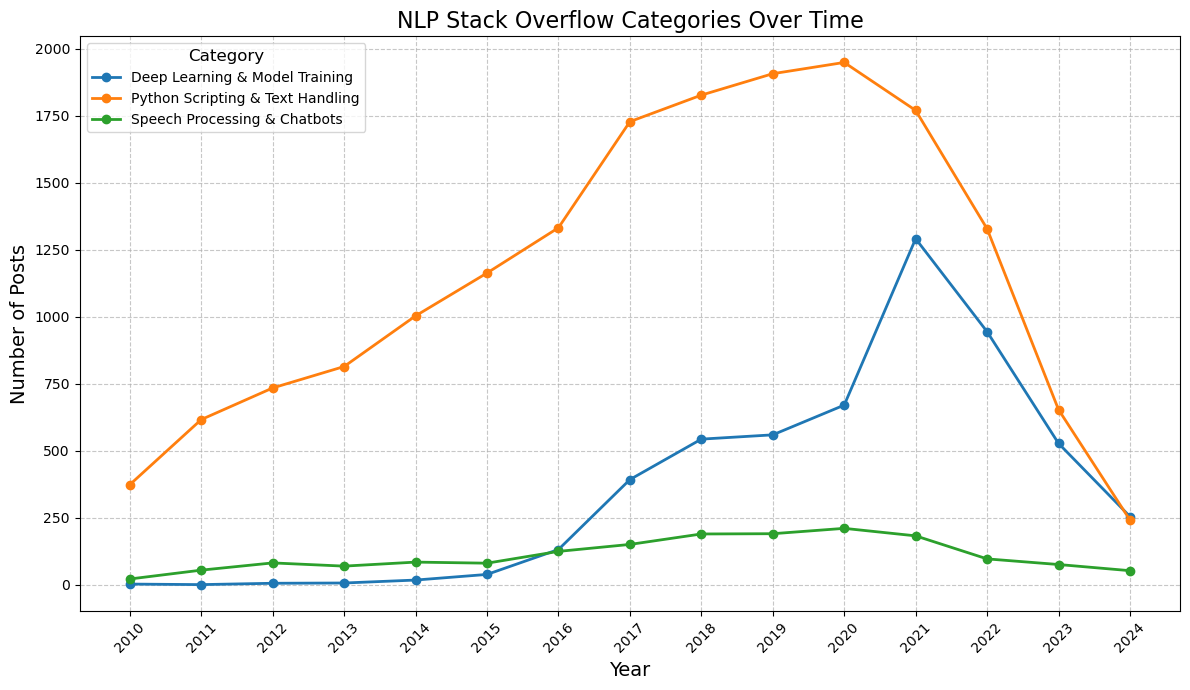

In [514]:
# 1. Line chart to show trends over time
plt.figure(figsize=(12, 7))
for category in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data[category], marker='o', linewidth=2, label=category)

plt.title('NLP Stack Overflow Categories Over Time', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Posts', fontsize=14)
plt.legend(title='Category', title_fontsize=12, fontsize=10, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(pivot_data.index, rotation=45)
plt.tight_layout()
# plt.savefig('category_trends_over_time.png', dpi=300)
plt.show()



1. **Python Scripting & Text Handling** (orange line) has been the dominant category throughout most of the period, showing steady growth from 2010 to 2019, peaking around 2019-2020, and then declining toward 2024.

2. **Deep Learning & Model Training** (blue line) shows minimal activity until around 2015-2016, when it begins a significant upward trend. It indicates that roughly before 2015-2016, deep learning mostly was not use to solve NLP tasks. It peaked in 2021, showing how deep learning became extremely popular in NLP 

3. **Speech Processing & Chatbots** (green line) shows modest but steady growth from 2010 to 2020, with a slight decline afterward.

The visualization reveals key shifts in the NLP field:
- Traditional text processing dominated early NLP questions
- Deep learning models began gaining significant traction around 2016
- Both categories show decline in recent years, possibly due to better documentation, more stable libraries, or shifts to newer platforms beyond Stack Overflow

<Figure size 1200x700 with 0 Axes>

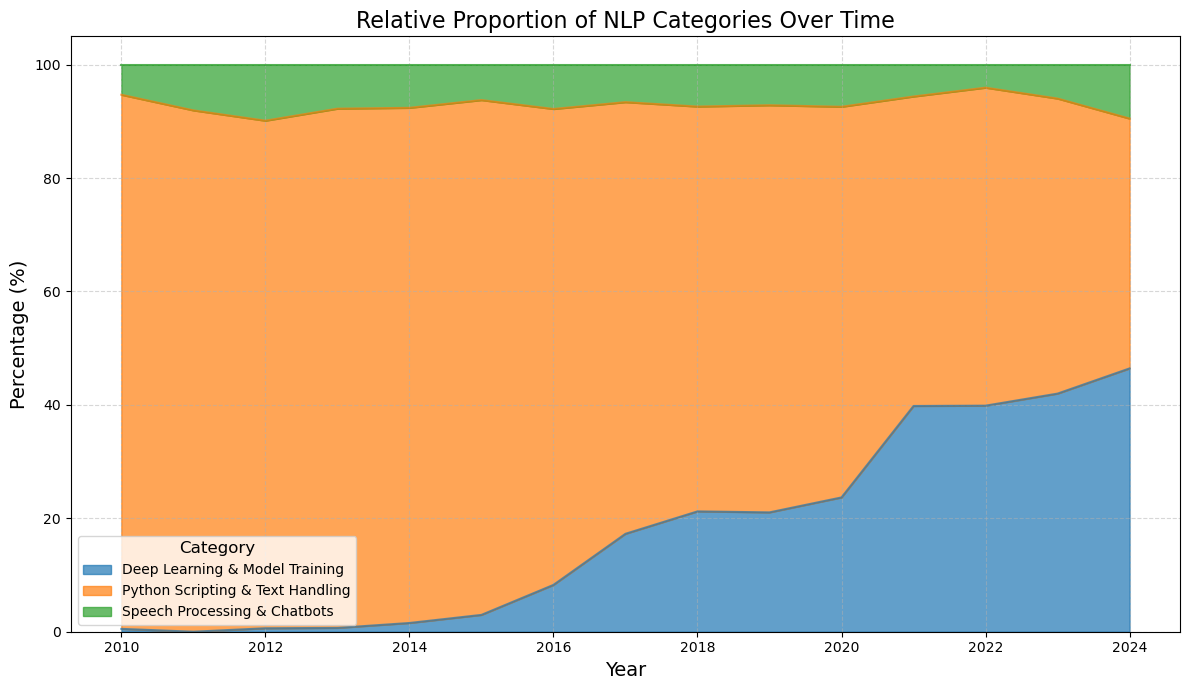

In [516]:
# 2. Stacked area chart to show relative proportions
plt.figure(figsize=(12, 7))
pivot_data_pct = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100
pivot_data_pct.plot.area(stacked=True, alpha=0.7, figsize=(12, 7))

plt.title('Relative Proportion of NLP Categories Over Time', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)
plt.legend(title='Category', title_fontsize=12, fontsize=10, loc='best')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
# plt.savefig('category_proportions_over_time.png', dpi=300)
plt.show()

This stacked area chart showing the relative proportion of NLP categories over time, it reveals trends in how the field has evolved:

**Python Scripting & Text Handling** (orange area) dominated the NLP questions on Stack Overflow from 2010 to around 2020, consistently accounting for 70-90% of all questions. This reflects how important text processing has been to NLP works
**Deep Learning & Model Training** (blue area) shows a sharp growth in the NLP fields. Before 2014, it was barely seen in the chart, however, it has been grown steadily from 2015 onward. By 2024, it represents nearly half of all NLP questions, showing how deep learning has transformed the field.
**Speech Processing & Chatbots** (green area) maintains a relatively consistent but modest proportion throughout the period, suggesting it's a specialized subfield yet hasn't seen the same explosive growth as deep learning.  
  
This visualization effectively demonstrates the transformation of NLP from a field dominated by traditional text processing techniques to one increasingly focused on deep learning approaches. The changing proportions clearly show how deep learning has become a core component of NLP work over the past decade, particularly accelerating after 2020.


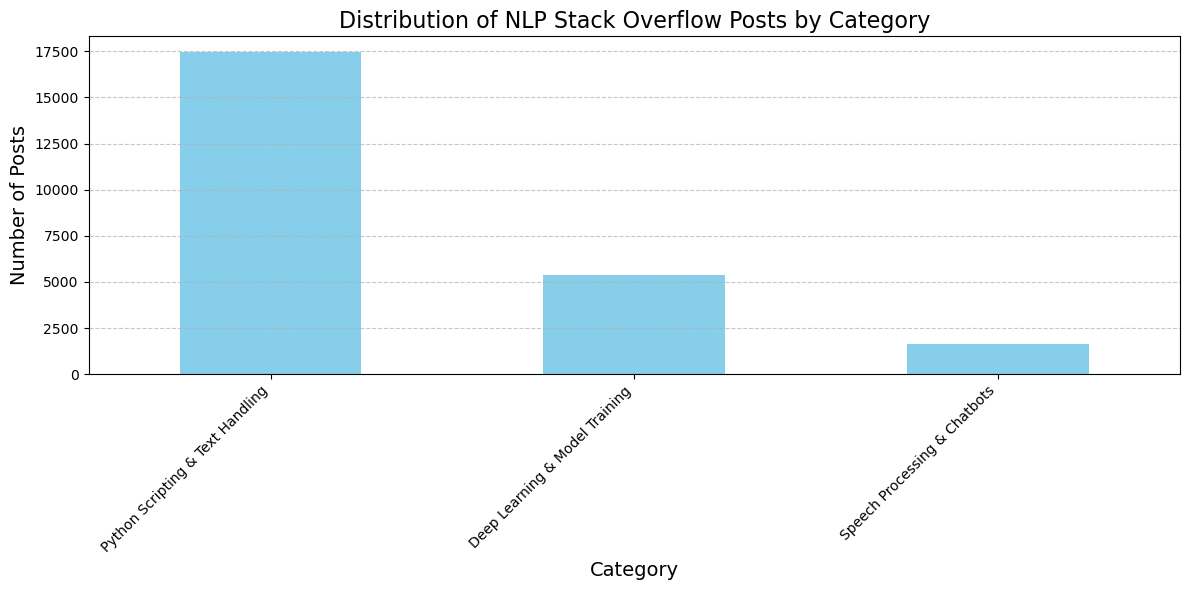

In [ ]:
# 3. Bar chart showing the total distribution of categories
plt.figure(figsize=(12, 6))
valid_data['predicted_category'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of NLP Stack Overflow Posts by Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Number of Posts', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('category_distribution.png', dpi=300)
plt.show()

The bar chart provides a clear overview of the total distribution of NLP Stack Overflow posts across your three categories:   

1. **Python Scripting & Text Handling** is by far the most common category with approximately 17,500 posts, representing the majority of NLP questions on Stack Overflow.
2. **Deep Learning & Model Training** is the second most frequent category with around 5,500 posts, showing significance yet with less volume than text handling questions.
3. **Speech Processing & Chatbots** is the least common category with approximately 1,500 posts, indicating it's a more specialized subfield within NLP on Stack Overflow.  
This suggests that while deep learning has grown in proportion, the basic text processing questions continue to represent the foundation of NLP work.


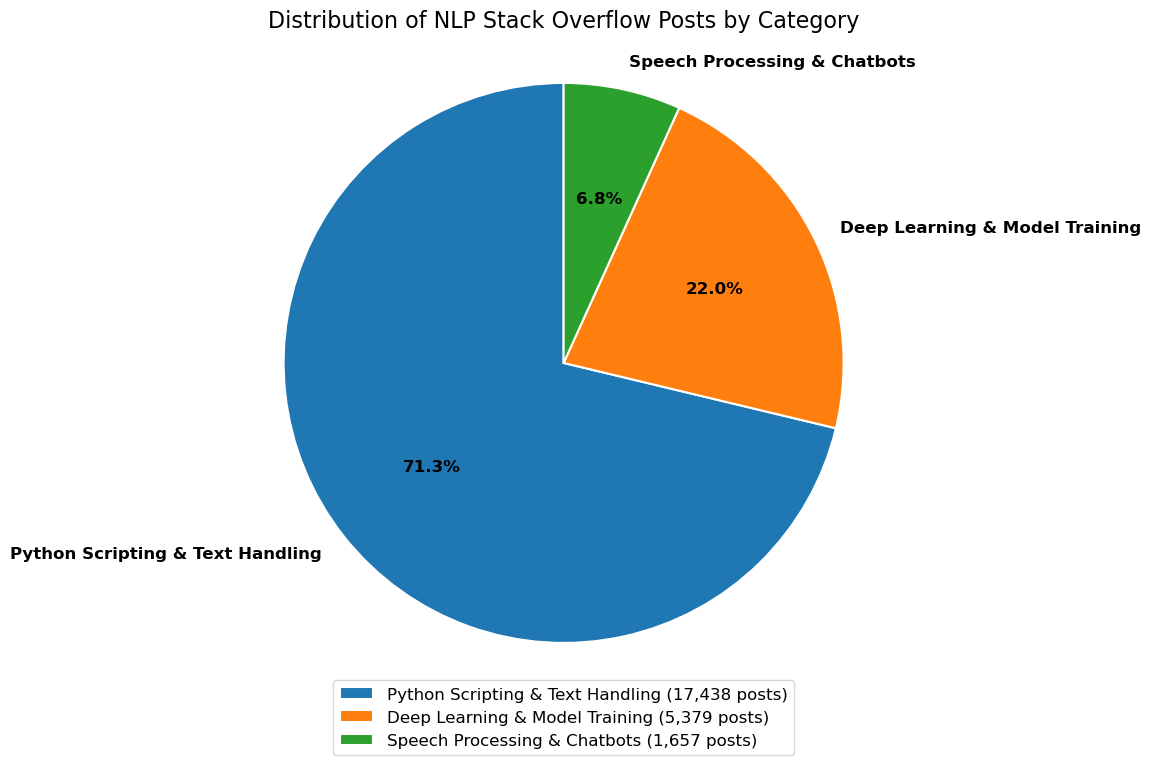

In [ ]:
plt.figure(figsize=(10, 8))

# Count the number of posts in each category
category_counts = valid_data['predicted_category'].value_counts()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  

plt.pie(category_counts, 
        labels=category_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        shadow=False,
        wedgeprops={'edgecolor': 'white', 'linewidth': 1.5},
        textprops={'fontsize': 12, 'weight': 'bold'})

plt.axis('equal')  

plt.title('Distribution of NLP Stack Overflow Posts by Category', fontsize=16, pad=20)

# Add a legend with post counts
legend_labels = [f"{category} ({count:,} posts)" for category, count in category_counts.items()]
plt.legend(legend_labels, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=1, fontsize=12)

# plt.savefig('nlp_categories_pie_chart.png', dpi=300, bbox_inches='tight')
plt.show()

1. __Python Scripting & Text Handling__ dominates with 71.3% of all posts  
2. __Deep Learning & Model Training__ accounts for 22.0% of posts
3. __Speech Processing & Chatbots__ accounts for just 6.8% of posts


## Recommendations for Further Analysis

1.  **Temporal Analysis:**
    * **What it involves:** This means looking at the data over time, track the volume and types of questions asked within each category across different time periods (e.g., month-over-month, year-over-year). Plot the frequency/score of certain keywords/tags or topics within categories over time.
    * **Why it's valuable:** It helps identify:
        * **Emerging Trends:** Are new technologies, frameworks, or problem types becoming more common? Are certain types of questions becoming less frequent, perhaps indicating a technology is becoming obsolete or better understood?
        * **Seasonality:** Are there specific times (e.g. related to project cycles, academic calendars) when certain question types peak?

2.  **Answer Quality Analysis:**
    * **What it involves:** This focuses on the solutions provided, specifically the accepted answers or highly-rated answers. We should analyze the content of these successful answers within each category. This could involve identifying common libraries, techniques, code patterns, or conceptual explanations used in effective solutions. Natural Language Processing (NLP) techniques could be used to summarize common themes or approaches.
    * **Why it's valuable:** It helps understand:
        * **Effective Solutions:** What do successful answers look like for different types of problems? What are the common characteristics of a high-quality answer in each category?
        * **Best Practices:** Are there common patterns or recommended approaches emerging from the accepted solutions?
        * **Knowledge Gaps:** Comparing accepted answers to the original questions can highlight where users commonly struggle and what kind of explanations are most helpful.

3.  **Difficulty Assessment:**
    * **What it involves:** This requires developing a system to classify questions or posts based on their complexity. This might involve looking at factors like: the length and detail of the question, the specificity of the terminology used, whether the question involves fundamental concepts vs. advanced integration, or potentially using machine learning models trained on expert ratings or proxies like answer length/complexity.
    * **Why it's valuable:** It allows for:
        * **Targeted Resources:** You can direct users to appropriate learning materials (tutorials for beginners, deep dives for experts) based on the difficulty of the questions they are viewing or asking.
        * **Skill Identification:** __It can help identify experts in specific advanced areas.__

4.  **Sub-categorization:**
    * **What it involves:** For very broad categories (e.g."Implementation Questions"), break them down into more granular sub-topics. This could be based on the specific technology involved (e.g., Python, Java, API integrations), the sub-problem being addressed, or the specific error types encountered. This often involves techniques like topic modeling (using NLP) or manual curation based on keyword analysis.
    * **Why it's valuable:** It improves:
        * **Navigability:** Makes it much easier for users to find relevant questions and answers.
        * **Expertise Matching:** Helps route questions to users with specific expertise in the sub-category.
        * **Trend Analysis Precision:** Allows for more precise temporal or quality analysis within these more focused sub-topics.



### References

[1] Jurafsky, D., & Martin, J. H. (2023). **Speech and Language Processing (3rd ed.)**. Prentice Hall.

[2] Bird, S., Klein, E., & Loper, E. (2009). **Natural Language Processing with Python**. O’Reilly Media Inc. [https://www.nltk.org/](https://www.nltk.org/)

[3] Explosion AI. **spaCy 3: Industrial-strength NLP**. [https://spacy.io/](https://spacy.io/)

[4] The pandas development team. (2020). *pandas-dev/pandas: Pandas*. Zenodo. [https://doi.org/10.5281/zenodo.3509134](https://doi.org/10.5281/zenodo.3509134)

[5] Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Duchesnay, E. (2011). **Scikit-learn: Machine Learning in Python**. *Journal of Machine Learning Research*, 12, 2825–2830. [https://scikit-learn.org/](https://scikit-learn.org/)

[6] Mueller, A. **wordcloud: A little word cloud generator in Python**. [https://github.com/amueller/word_cloud](https://github.com/amueller/word_cloud)

[7] Hunter, J. D. (2007). **Matplotlib: A 2D graphics environment**. *Computing in Science & Engineering*, 9(3), 90–95. [https://matplotlib.org/](https://matplotlib.org/)

[8] Speer, R. (2015). **ftfy: Fixes Text For You**. [https://ftfy.readthedocs.io/](https://ftfy.readthedocs.io/)

[9] Stack Exchange Inc. **Stack Exchange API v2.3 Documentation**. [https://api.stackexchange.com/](https://api.stackexchange.com/)

[10] OpenAI. (2024). **ChatGPT**. *Used for code suggestions and enhancements during preprocessing steps.* [https://openai.com/chatgpt](https://openai.com/chatgpt)

[11] Google DeepMind. (2024). **Gemini**. *Used to support explanations and alternative phrasing ideas.* [https://deepmind.google/technologies/gemini/](https://deepmind.google/technologies/gemini/)

[12] CoLearning Lounge. **NLP - Data Preprocessing and Cleaning**. Kaggle. [https://www.kaggle.com/code/colearninglounge/nlp-data-preprocessing-and-cleaning](https://www.kaggle.com/code/colearninglounge/nlp-data-preprocessing-and-cleaning)

[13] Rajkumar, S. **Getting Started with Text Preprocessing**. Kaggle. [https://www.kaggle.com/code/sudalairajkumar/getting-started-with-text-preprocessing](https://www.kaggle.com/code/sudalairajkumar/getting-started-with-text-preprocessing)

[14] Islam, F. **NLP Tutorial 2: Text Preprocessing**. Kaggle. [https://www.kaggle.com/code/faizulislam19095/nlp-tutorial-2-text-preprocessing](https://www.kaggle.com/code/faizulislam19095/nlp-tutorial-2-text-preprocessing)

[15] Nguyen, L. **NLP Preprocessing & Feature Extraction Methods A-Z**. Kaggle. [https://www.kaggle.com/code/longtng/nlp-preprocessing-feature-extraction-methods-a-z](https://www.kaggle.com/code/longtng/nlp-preprocessing-feature-extraction-methods-a-z)

[16] Kelde9. **Tutorial Preprocessing NLP | English & French Text**. Kaggle. [https://www.kaggle.com/code/kelde9/tutorial-preprocessing-nlp-english-french-text](https://www.kaggle.com/code/kelde9/tutorial-preprocessing-nlp-english-french-text)
